# TaxaPLN: a taxonomy-aware augmentation strategy for microbiome-trait classification including metadata

> Microbiome datasets are often high dimensional, limited in size and highly variable, making it hard for machine learning models to find reliable patterns.
> In this context, data augmentation emerges as a promising solution to improve model performance by generating synthetic samples.
>
> Here, we develop and evaluate TaxaPLN, an augmentation strategy for microbiome data which leverages taxonomic information through PLN-Tree coupled with a VAMP sampler to generate new biologically faithful microbiome compositions. 
> It can also generate microbiomes conditioned on exogenous information, allowing for covariate-aware augmentation.

This notebook aims at reproducing the experiments from our [original paper](https://arxiv.org/abs/2507.03588). Specifically, we perform data augmentation on 9 microbiome studies from the `curatedMetagenomicData` [R package](https://bioconductor.org/packages/3.16/data/experiment/html/curatedMetagenomicData.html), which is known for ressourcing high-quality and curated microbiome datasets. We benchmark our augmentation strategy, TaxaPLN, against state-of-the-art augmentation methods such as [PhyloMix](https://doi.org/10.1093/bioinformatics/btaf014), [Vanilla Mixup](https://arxiv.org/abs/1710.09412), and [Compositional Cutmix](https://arxiv.org/abs/2205.09906). Ablation study of the taxonomy is performed by evaluating the performance gains against the regular Poisson Log-Normal (PLN) model.

## Prerequisites

### Dependencies
```bash
pip install plntree==0.0.1
pip install pyPLNmodels==0.0.69
pip install scikit-bio==0.6.3
pip install ete4==4.1.1
pip install POT==0.9.5
```
### Models training
Before running this notebook, you need to have pre-trained the PLN-Tree models for each study considered in this notebook.

You have two alternatives:
- Fetching the pre-trained models archived on Zenodo (49.3 Go ZIP) and decompressing them into the `cache` folder.
- Training the PLN-Tree models using the provided scripts `curated_train_dataset_CV.py` (for covariate-aware and vanilla augmentation) and `curated_train_dataset_holdout.py` (for HMP hold-out study). We recommend checking the tutorial to learn more on the scripts usage on [GitHub](https://github.com/AlexandreChaussard/PLNTree-package/tree/master/taxapln#%EF%B8%8F-reproducing-our-results). Note that around 250 models need to be trained per dataset to satisfy the protocol of our experiments, which takes around 3 days per dataset to complete on medium quality hardware.

To run the conditional augmentation, you also need to edit the `pyPLNmodels` package for PLN models which appears to be too sensitive to covariates invertibility. You can edit the package at `_closed_forms.py:66` to use `torch.linalg.pinv` instead of `torch.inverse` when the error arise in the Covariate-aware augmentation section.

## Disclaimer

In this notebook, the `TaxaPLN` augmentation from our manuscript is also referred to as `VampPLN-Tree`. Similarly, `VampPLN` designates the `PLN` model of our manuscript.

## References
- Chaussard, A., Bonnet, A., Le Corff, S., Sokol, H.. TaxaPLN: a taxonomy-aware augmentation strategy for microbiome-trait classification including metadata. (2025) arXiv preprint arXiv:2507.03588.
- Chaussard, A., Bonnet, A., Gassiat, E., Le Corff, S.. Tree-based variational inference for Poisson log-normal models. Statistics and Computing 35, 135 (2025). https://doi.org/10.1007/s11222-025-10668-w
- Pasolli E, Schiffer L, Manghi P, Renson A, Obenchain V, Truong D, Beghini F, Malik F, Ramos M, Dowd J, Huttenhower C, Morgan M, Segata N, Waldron L (2017). “Accessible, curated metagenomic data through ExperimentHub.” Nat. Methods, 14(11), 1023–1024. ISSN 1548-7091, 1548-7105, doi: 10.1038/nmeth.4468.
- Yifan Jiang, Disen Liao, Qiyun Zhu, Yang Young Lu, PhyloMix: enhancing microbiome-trait association prediction through phylogeny-mixing augmentation, Bioinformatics, Volume 41, Issue 2, February 2025, btaf014, https://doi.org/10.1093/bioinformatics/btaf014
- Gordon-Rodriguez, E., Quinn, T., & Cunningham, J. P. (2022). Data augmentation for compositional data: Advancing predictive models of the microbiome. Advances in Neural Information Processing Systems, 35, 20551-20565.
- Zhang, H., Cisse, M., Dauphin, Y. N., & Lopez-Paz, D. (2017). mixup: Beyond empirical risk minimization. arXiv preprint arXiv:1710.09412.

# Useful libraries

We import some libraries that we are going to use throughout this notebook.

In [1]:
# Useful libraries for data processing
import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import os


from plntree.utils.utils import load_losses, load_model_weights, save_losses, save_model_weights
from pln import *
from experiments_utils import *

# Adjustments for plot styles
sns.set_style('whitegrid')
viridis = matplotlib.colormaps.get_cmap('viridis')
# Seed for reproducibility
seed = 0
# Save folder of pre-trained models and stored results
save_folder = 'cache/'

# Building covariates

First, we provide adapted preprocessing of covariates to facilitate gradient propagation in trained neural networks.

Countries are one-hot encoded, age is ordinally encoded, sex is binary encoded and BMI is min-max scaled.

In [2]:
# Preprocess the covariates
def preprocess_covariates(cov):
    """
    Covariates preprocessing function including country of residence, sex, age, BMI of the patients.
    """
    # Select only a few covariates to be used
    cov_emb = cov.copy()[['country', 'age_category', 'gender', 'BMI']].dropna()
    if cov_emb.empty:
        return cov.copy()

    # One-hot encoding of the countries
    for country in cov_emb['country'].unique():
        cov_emb[country] = [1 * (cov_emb.country.iloc[i] == country) for i in range(cov_emb.shape[0])]
    cov_emb = cov_emb.drop(columns=['country'])

    # Define the order of the ages
    ages = {'newborn': 0, 'child': 0.2, 'schoolage': 0.5, 'adult': 0.7, 'senior': 1}
    cov_emb['age_category'] = cov_emb['age_category'].apply(lambda x: ages[x])

    # Categorical encoding for sex
    sex = {'male': 0, 'female': 1}
    cov_emb['gender'] = cov_emb['gender'].apply(lambda x: sex[x])

    # Normalization of BMI
    cov_emb['BMI'] = cov_emb['BMI'].astype(float)
    cov_emb['BMI'] = (cov_emb['BMI'] - cov_emb['BMI'].min()) / (cov_emb['BMI'].max() - cov_emb['BMI'].min())

    cov_emb = cov_emb.astype(float)
    return cov_emb

# Useful loaders for PLN-Tree

These are some functions that are necessary to load PLN-Tree models based on the 5-Fold CV training scheme. It mostly provides nomenclature of files to ensure we have a unique pipeline for all the experiments. In general settings, you might not need to introduce that many functions to use PLN-Tree. Refer to our [TaxaPLN quickstart](https://github.com/AlexandreChaussard/PLNTree-package/tree/master/taxapln#%EF%B8%8F-general-usage) if you want to use PLN-Tree in a more straight-forward way. 

In [3]:
def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32,
                        n_after_layers=2):
    """
    Embedding and parameterization of PLN-Tree residual backward approximation 
    """
    preprocessing = 'proportion'
    params = {
            'method': 'residual',
            'embedder_type': embedder_type,
            'embedding_size': embedding_size,
            'n_embedding_layers': n_embedding_layers,
            'n_embedding_neurons': n_embedding_neurons,
            'n_after_layers': n_after_layers,
            'counts_preprocessing': preprocessing
    }
    name = params['method'] + f'-Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}-{preprocessing}'
    return name, params
    
def load_plntree(X_train, cov_train, cov_params, n_latent_layers, variational_approx, load_file=None, save_folder='cache/', verbose=False):
    """
    Loader for PLN-Tree models given specified parameters and training sets
    """
    seed_all(seed)
    latent_dynamic = {
        'n_layers': n_latent_layers,
        'counts_preprocessing': 'proportion',    
    }
    estimator = PLNTree(
        counts=X_train,
        covariates=cov_train,
        latent_dynamic=latent_dynamic,
        variational_approx=variational_approx,
        covariates_params=cov_params,
        device='cpu',
        seed=seed,
    )
    if verbose:
        print(save_folder + load_file)
    load_model_weights(estimator, save_folder + load_file)
    losses = load_losses(save_folder + load_file + '_loss')
    try:
        monitored = load_losses(save_folder + load_file + '_monitored')
    except:
        monitored = []

    estimator.mu_fun[0].data = estimator.mu_fun[0].data.to(estimator.hierarchical_counts.dtype)
    return estimator, losses, monitored

# Datasets

We now import all the datasets that we study in our paper, accompagnied by their metadata. The `cMD` module of our `plntree` package is a useful loader for `curatedMetagenomicData` already pre-pulled datasets.

In [4]:
from plntree.data import cMD

# Importing patients covariates
metadata = cMD.metadata()

In [5]:
# Defining all the datasets and the labels of interest
data = {
    'WirbelJ_2018': ['CRC', 'control'],
    'HMP_2019_ibdmdb': ['IBD', 'control'],
    'ZhuF_2020': ['schizophrenia', 'control'],
    'KosticAD_2015': ['T1D', 'control'],
    'RubelMA_2020': ['STH', 'control'],
    'ZellerG_2014': ['adenoma', 'control'],
    'YachidaS_2019': ['adenoma', 'control'],
    'YuJ_2015': ['CRC', 'control'],
    'NielsenHB_2014': ['IBD', 'control'],
}

In [6]:
# Display the content of each study, excluding label specific information.
for study in list(data.keys()):
    m = metadata[metadata['study_name'] == study]
    print(study, cMD.get_study(study=study, prevalence=.15, taxonomic_levels=('c', 's')).shape)
    d = []
    for j, disease in enumerate(m['study_condition'].unique()):
        c = m[m['study_condition'] == disease].shape[0]
        d += [c]
        print('   ', disease, c)

WirbelJ_2018 (125, 189)
    CRC 60
    control 65
HMP_2019_ibdmdb (1627, 103)
    IBD 1201
    control 426
ZhuF_2020 (171, 155)
    control 81
    schizophrenia 90
KosticAD_2015 (120, 104)
    control 89
    T1D 31
RubelMA_2020 (175, 103)
    STH 89
    control 86
ZellerG_2014 (156, 216)
    control 61
    CRC 53
    adenoma 42
YachidaS_2019 (616, 177)
    CRC 258
    control 251
    carcinoma_surgery_history 40
    adenoma 67
YuJ_2015 (128, 198)
    CRC 74
    control 54
NielsenHB_2014 (396, 174)
    control 248
    IBD 148


In [7]:
from plntree import PLNTree
from plntree.data import cMD

# We select the bacteria descriptions from the class to the species level
levels = ('c', 's')
# Prevalence thresholding is performed at 15% presence at least
prevalence = 0.15
# We set a total count of 100 000 for resampling of proportions to counts using multinomial
total_reads = 100_000

def get_disease_samples(disease, X, meta):
    """
    Fetch the specific samples in X such that they have the given condition
    """
    disease_index = meta[meta.study_condition == disease].index
    return X.loc[disease_index].copy()

def get_dataset(study, n_cv, train_proportion=0.8, cov=False, save_folder='cache/', return_all=False, seed=0):
    """
    Get the cross-validation datasets for a given study.
    """
    seed_all(seed)
    metadata = cMD.metadata()
    counts = cMD.get_study(
        study=study,
        prevalence=prevalence,
        total_reads=total_reads,
        taxonomic_levels=levels,
    )
    metadata = metadata.loc[counts.index]
    # Filter metadata
    covariates = preprocess_covariates(metadata)
    levels_str = ''
    for level in levels:
        levels_str += level
    prefix_all = f'plntreeCV-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'

    dic_data = {}
    for disease in data[study]:
        datasets = []
        for cv in range(n_cv):
            cv_file_name = save_folder + prefix_all + '-cv' + str(cv) + '.csv'
            if not os.path.isfile(cv_file_name):
                raise ValueError(cv_file_name + ' not found. Did you pre-train the PLN-Tree models? If not, refer to the prerequisites at the top of the notebook.')
            df_cv = pd.read_csv(cv_file_name)
            df_cv['patient_id'] = df_cv['patient_id'].astype(str)
            df_cv['fold'] = df_cv['fold'].astype(int)
            folds = []
            for k in range(5):
                train_fold = df_cv[df_cv['fold'] != k]
                test_fold = df_cv[df_cv['fold'] == k]
                train_indices = list(train_fold['patient_id'].apply(lambda x: x.replace(f'_{study}', '')).values.flatten())
                test_indices = list(test_fold['patient_id'].apply(lambda x: x.replace(f'_{study}', '')).values.flatten())
                for ind in test_indices:
                    if ind in train_indices:
                        raise ValueError('Data leak issue in dataset construction.')
                X_train = counts.loc[train_indices].copy()
                X_test = counts.loc[test_indices].copy()
                X_train = get_disease_samples(disease, X_train, metadata.loc[X_train.index])
                X_test = get_disease_samples(disease, X_test, metadata.loc[X_test.index])
                cov_train = covariates.loc[X_train.index].copy()
                cov_test = covariates.loc[X_test.index].copy()
                if not cov:
                    cov_train = None
                    cov_test = None
                folds.append((X_train, cov_train, X_test, cov_test))
            datasets.append(folds)
        dic_data[disease] = datasets
    if return_all:
        return dic_data, counts, metadata
    else:
        return dic_data

def get_plntree(study, n_cv, train_proportion=0.8, cov=False, save_folder='cache/'):
    """
    Fetch the PLN-Tree models associated to the splits in a given cross-validation scheme.
    """
    prevalence = 0.15
    levels_str = ''
    for level in levels:
        levels_str += level
    prefix_all = f'plntreeCV-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'

    # Parameters for the PLN-Tree model used in our experiments
    cov_params = {'type':'film', 'n_heads': 0, 'n_layers': 2}
    n_latent_layers, (emb_name, variational_approx) = (1, embedder_params(
        embedder_type='GRU',
        embedding_size=32,
        n_embedding_layers=2,
        n_embedding_neurons=32,
        n_after_layers=2
        )
    )

    dic_data, counts, meta = get_dataset(study, n_cv, train_proportion=train_proportion, cov=cov, save_folder=save_folder, return_all=True)
    models = {}
    for disease in dic_data.keys():
        datasets = dic_data[disease]
        prefix = prefix_all + '-' + disease
        models[disease] = {}
        for cv, folds in enumerate(datasets):
            models[disease][cv] = []
            for k, (X_train, cov_train, X_test, cov_test) in enumerate(folds):
                if not cov:
                    load_file = prefix + '_' + str(n_latent_layers) + '--' + emb_name + f'_cv{cv}-{k}'
                else:
                    load_file = prefix + '_' + str(n_latent_layers) + '--all' + '-' + cov_params['type'] + str(cov_params['n_heads']) + '.' + str(cov_params['n_layers']) + '--' + emb_name + f'_cv{cv}-{k}'
                X_train_disease = get_disease_samples(disease, X_train, meta.loc[X_train.index])
                cov_train_disease = cov_train.loc[X_train_disease.index] if cov else None

                estimator, losses, monitor = load_plntree(
                    X_train_disease, cov_train_disease, cov_params, n_latent_layers, variational_approx, 
                    load_file=load_file, save_folder=save_folder
                )
                models[disease][cv].append((estimator, losses, X_train, X_test))
    return models

# Vanilla Data Augmentation with TaxaPLN

In this section, we take a closer look at vanilla (without covariates) data augmentation of microbiome data. The contribution is two-fold:
- Show that TaxaPLN generations preserve biological metrics of the original cohorts.
- Illustrate gains with TaxaPLN augmentation in classification tasks.

## Sanity check about PLN-Tree training

First, we check that the trained models do not have any pathological behavior during training by investigating the ELBO.

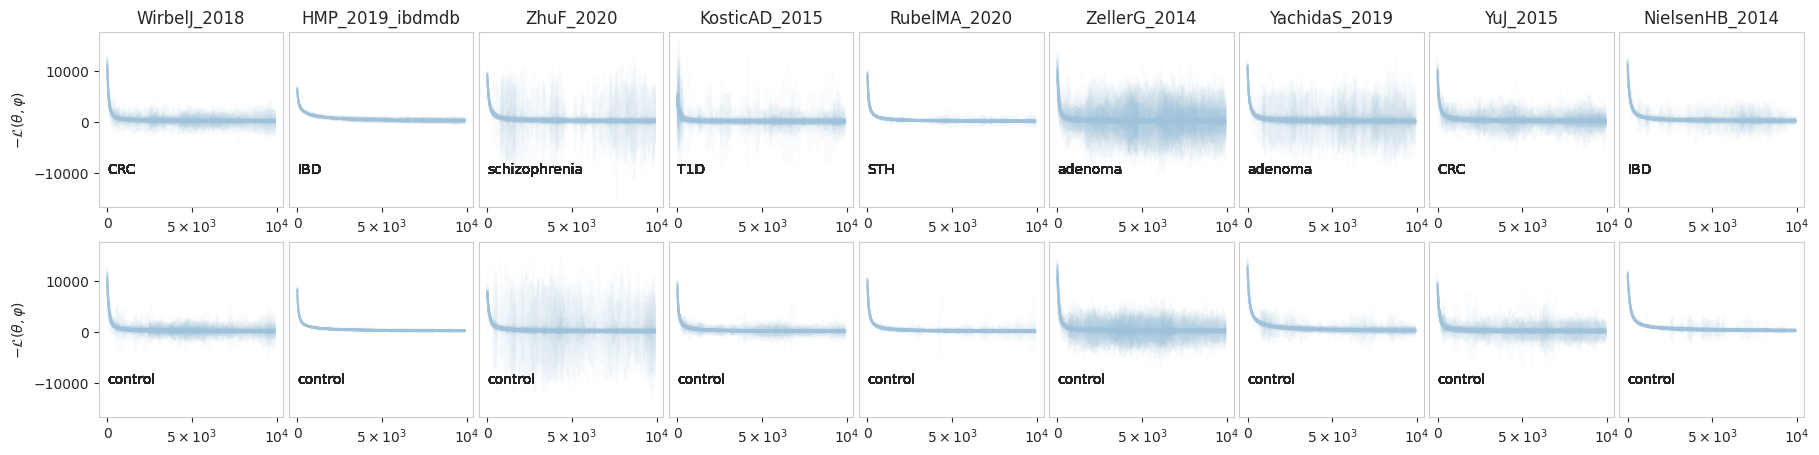

In [9]:
n_cv = 5
sns.set_style('whitegrid', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
fig, axs = plt.subplots(2, len(data), figsize=(22,5), sharey=True, gridspec_kw={'wspace': 0.03})

for i, study in enumerate(data):
    plntree_models = get_plntree(study, n_cv, cov=False)
    for j, disease in enumerate(data[study]):
        for cv in range(n_cv):
            for (plntree, losses, X_train, X_test) in plntree_models[disease][cv]:
                axs[j][i].plot(losses[100:], color='C0', alpha=0.02)
                #axs[j][i].set_yscale('symlog')
                axs[j][i].text(0., -10e3, disease)
        if i != 0:
            axs[j][i].get_yaxis().set_visible(False)
        axs[j][i].set_xticks([0, 5000, 10000])
        axs[j][i].set_xticklabels(['0', '$5 \\times 10^3$', '$10^4$'])
        axs[j][i].grid(False)
    axs[0][i].set_title(study)
    axs[0][0].set_ylabel('$-\\mathcal{L}(\\theta, \\varphi)$')
    axs[1][0].set_ylabel('$-\\mathcal{L}(\\theta, \\varphi)$')
savefig('PLNTree_ELBOs_vanilla', 'jpg', 350)

Then, we look into some samples and the structure of the taxonomy for the various datasets.

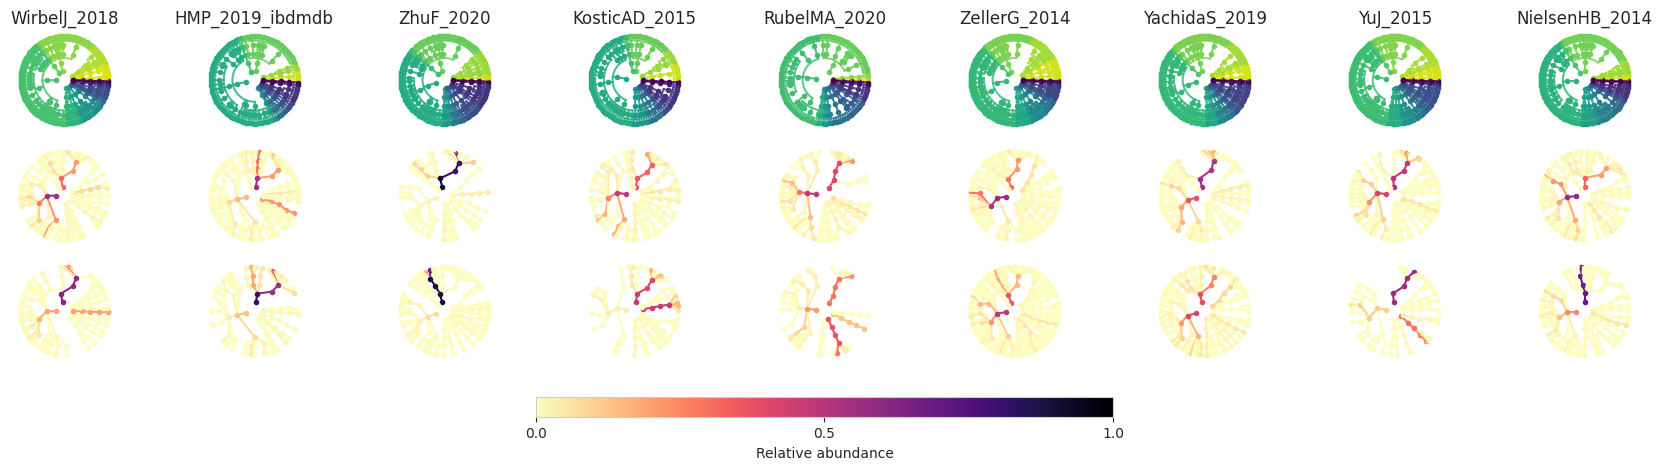

In [30]:
import matplotlib.colors as mcolors

n_cv = 1

fig, axs = plt.subplots(3, len(data), figsize=(22,5), sharey=True, gridspec_kw={'wspace': 0.03})

for i, study in enumerate(data):
    plntree_models = get_plntree(study, n_cv, cov=False)
    for (plntree, losses, X_train, X_test) in plntree_models['control'][n_cv-1]:
        plntree.tree.plot(figaxis=(None, axs[0][i]), colormap='viridis_r')
        plntree.tree.plot(counts=plntree.counts.iloc[0], figaxis=(fig, axs[1][i]), colormap='magma_r')
        plntree.tree.plot(counts=plntree_models[data[study][0]][n_cv-1][0][0].counts.iloc[0], figaxis=(fig, axs[2][i]), colormap='magma_r')
        axs[0][i].set_title(study)
        axs[1][i].set_ylabel('control')
        axs[1][i].set_ylabel(data[study][0])
        break

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.get_cmap('magma_r')
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=fig.axes,
    orientation='horizontal',
    fraction=0.05,  
    pad=0.1,           # Padding between the plot and the colorbar
    aspect=30          # Aspect ratio
)

cbar.set_ticks([0, 0.5, 1])
cbar.set_label("Relative abundance")
savefig('taxonomies_and_taxaabundance_data', 'jpg', 350)

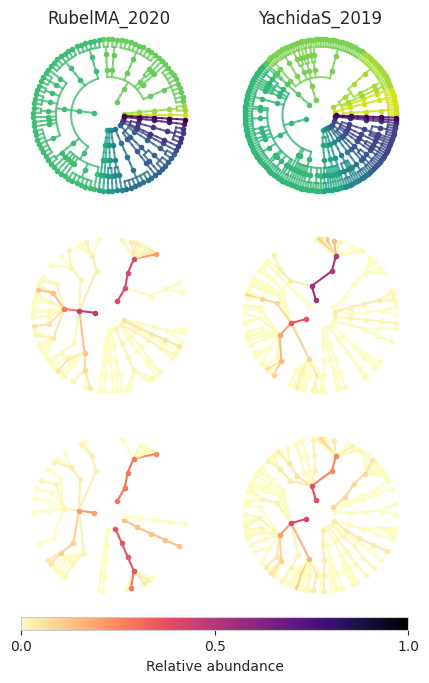

In [31]:
import matplotlib.colors as mcolors

n_cv = 1
specific = ['RubelMA_2020', 'YachidaS_2019']
fig, axs = plt.subplots(3, len(specific), figsize=(5,8))

for i, study in enumerate(specific):
    plntree_models = get_plntree(study, n_cv, cov=False)
    for (plntree, losses, X_train, X_test) in plntree_models['control'][n_cv-1]:
        plntree.tree.plot(figaxis=(None, axs[0][i]), colormap='viridis_r')
        plntree.tree.plot(counts=plntree.counts.iloc[0], figaxis=(fig, axs[1][i]), colormap='magma_r')
        plntree.tree.plot(counts=plntree_models[data[study][0]][n_cv-1][0][0].counts.iloc[0], figaxis=(fig, axs[2][i]), colormap='magma_r')
        axs[0][i].set_title(study)
        axs[1][i].set_ylabel('control')
        axs[1][i].set_ylabel(data[study][0])
        break

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.get_cmap('magma_r')
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=fig.axes,
    orientation='horizontal',
    fraction=0.05,  
    pad=0.03,          # Padding between the plot and the colorbar
    aspect=30          # Aspect ratio
)

cbar.set_ticks([0, 0.5, 1])
cbar.set_label("Relative abundance")
savefig('taxonomies_and_taxaabundance_data_specific', 'jpg', 350)

## Alpha diversity benchmark

We evaluate the preservation of $\alpha$-diversity metrics of the cohorts by generating samples with the different methods and assessing the metrics' resemblance with that of the original cohort. If these metrics are not well reproduced by a given method, this could preclude downstream analysis since the biological signal is altered.

Among the $\alpha$-diversity metrics we focus on the Shannon and Simpson metrics.

In [11]:
from baseline_augmentation import vanilla_mixup, compositional_cutmix, phylomix
import pickle

cv = 1
n_samples = 500

X = {}
# First, we generate samples with each strategy
for i, study in enumerate(data):
    print('[*]', study)
    plntree_models = get_plntree(study, cv, cov=False)
    X_disease = {}
    for j, disease in enumerate(data[study]):
        print('    |-', disease)
        # Initialize dictionary of augmented data
        X_aug = None
        for (plntree, losses, X_train, X_test) in plntree_models[disease][cv-1]:
            seed_all(seed)
            # Generated synthetic microbiome samples with every methods, and store for analysis
            X_plntree = plntree.vamp_sample(n_samples, seed=seed)[0]
            # Ablation study: learning PLN (no taxonomic information)
            pln = Pln(endog=plntree.counts)
            pln.fit()
            X_pln = torch.zeros_like(X_plntree)
            seed_all(seed)
            X_pln[:, -1] = vamp_sample(pln, n_samples)[0]
            # Other baseline augmentation methods
            seed_all(seed)
            X_vanillamixup = vanilla_mixup(plntree.counts.to_numpy(), n_samples)
            X_vanillamixup = pd.DataFrame(data=X_vanillamixup, columns=plntree.counts.columns)
            X_vanillamixup = plntree.tree.hierarchical_counts(X_vanillamixup)

            seed_all(seed)
            X_compositionalcutmix = compositional_cutmix(plntree.counts.to_numpy(), n_samples)
            X_compositionalcutmix = pd.DataFrame(data=X_compositionalcutmix, columns=plntree.counts.columns)
            X_compositionalcutmix = plntree.tree.hierarchical_counts(X_compositionalcutmix)

            seed_all(seed)
            X_phylomix = phylomix(plntree.counts, n_samples, tree='taxonomy')
            X_phylomix = pd.DataFrame(data=X_phylomix, columns=plntree.counts.columns)
            X_phylomix = plntree.tree.hierarchical_counts(X_phylomix)

            X_aug_fold = {
                    disease: plntree.hierarchical_counts,
                    'Vanilla-Mixup': X_vanillamixup,
                    'Compositional-Cutmix': X_compositionalcutmix,
                    'PhyloMix': X_phylomix,
                    'PLN': X_pln,
                    'TaxaPLN': X_plntree,
                }
            
            if X_aug is None:
                X_aug = X_aug_fold
            else:
                for key in X_aug:
                    X_aug[key] = torch.cat((X_aug[key], X_aug_fold[key]))
        X_disease[disease] = X_aug
    X[study] = X_disease

[*] WirbelJ_2018
    |- CRC
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 454 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 467 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 450 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 489 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 453 iterations
    |- control
Setting the offsets as the log of the

In [12]:
# Dictionary of colors for the strategies
colors = {
    'Original': '#1E90FF',
    'Vanilla-Mixup': '#F3C4A3', 
    'Compositional-Cutmix': '#B6C3E7',             
    'PhyloMix': '#F5CCE8',   
    'PLN': '#A1D6C2',         
    'TaxaPLN': 'red',                    
}

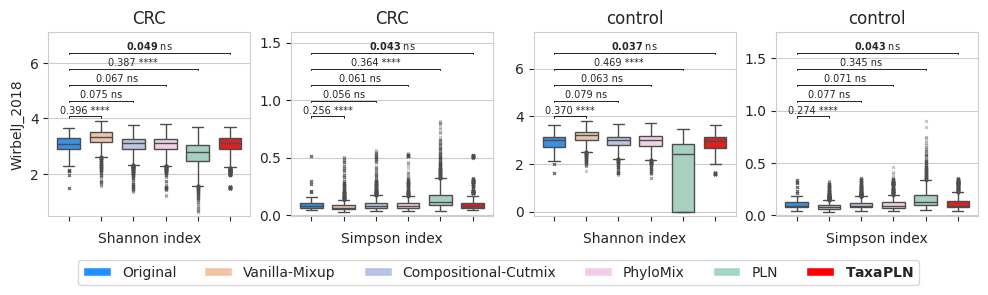

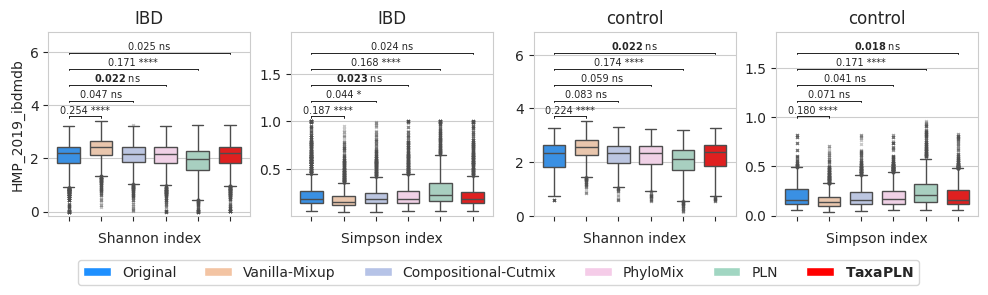

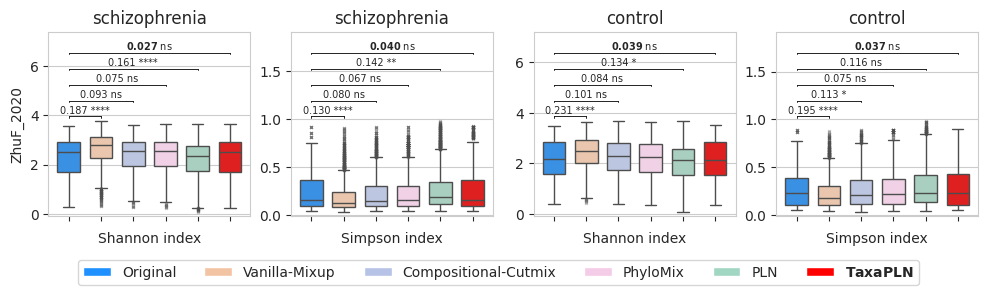

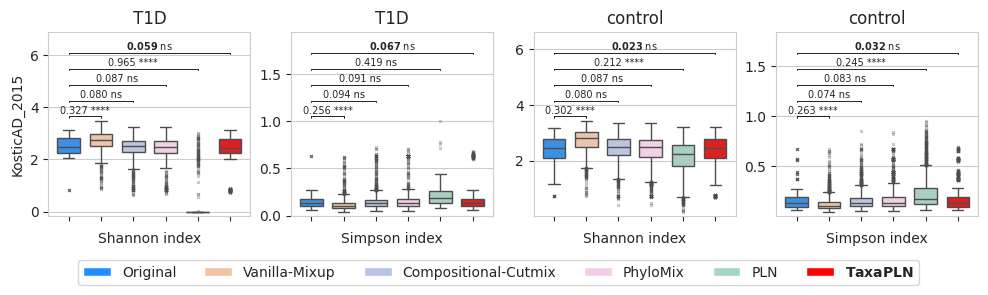

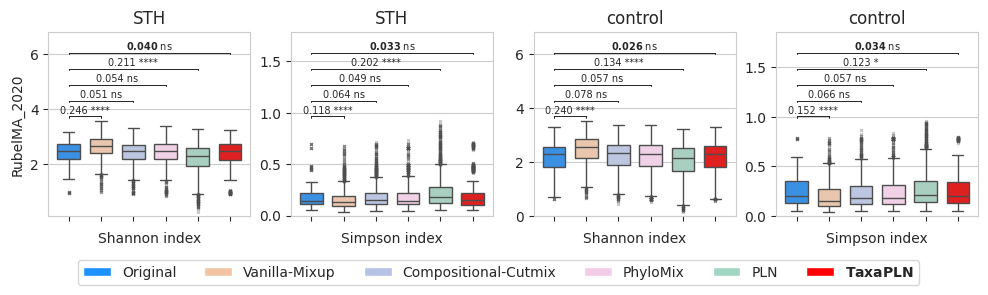

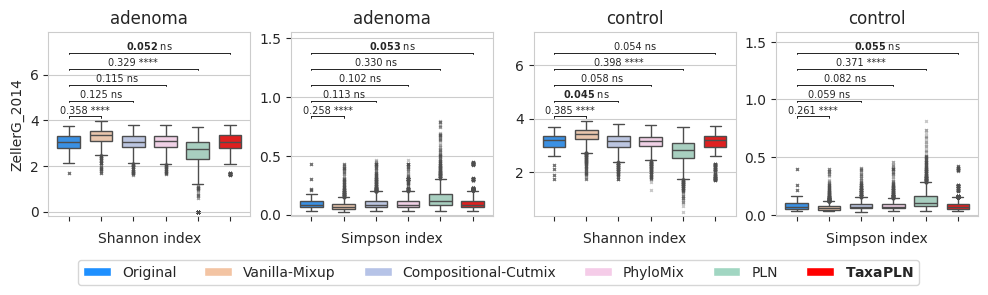

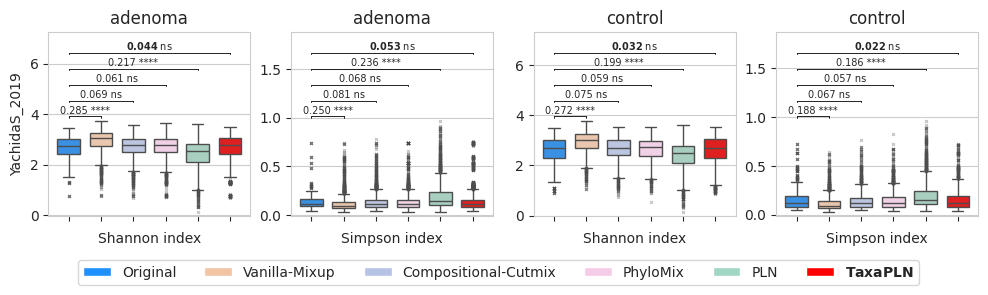

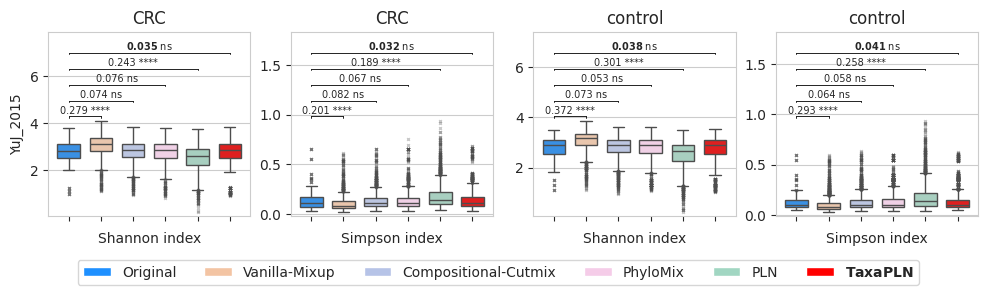

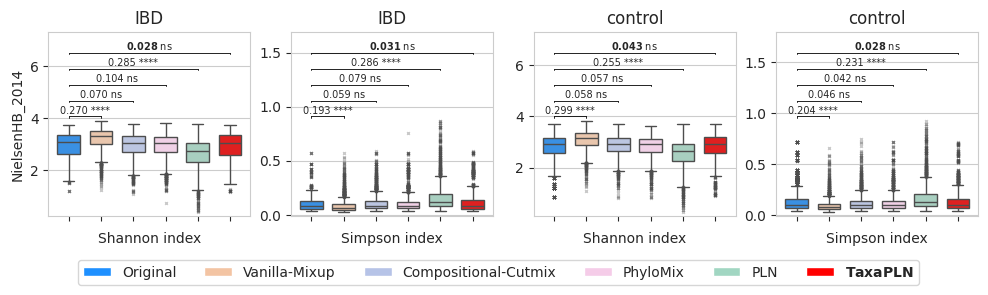

In [13]:
from scipy.stats import ks_2samp, mannwhitneyu
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Display of Alpha diversity boxplots with p-values of Mann-Whitney U tests and KS distance
alpha_metrics = {
    'Shannon index': shannon_index,
    'Simpson index': simpson_index,
}

pvalues = {
    'Shannon index': {group:[] for group in colors},
    'Simpson index': {group:[] for group in colors},
}

def pvalue_map(pvalue):
    if pvalue <= 0.0001:
        return '****'
    elif pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return 'ns'


for i, study in enumerate(X):
    fig, axs = plt.subplots(1, len(alpha_metrics)*2, figsize=(12, 2.3))
    for j, disease in enumerate(X[study]):
        alpha_div = pd.DataFrame()
        for strategy in X[study][disease]:
            label = strategy if strategy != disease else 'Original'
            X_L = X[study][disease][strategy][:, -1]
            df = pd.DataFrame()
            for metric, metric_fun in alpha_metrics.items():
                df[metric] = metric_fun(X_L)
            df['Group'] = label
            alpha_div = pd.concat((alpha_div, df), ignore_index=True)

        # fixed plotting order: Original first, then others as they appear
        order_groups = ['Original'] + [g for g in alpha_div['Group'].unique() if g != 'Original']

        for k, metric in enumerate(alpha_metrics):
            seed_all(seed)
            ax = axs[j*len(alpha_metrics) + k]

            sns.boxplot(
                data=alpha_div,
                x="Group", y=metric,
                width=0.7, order=order_groups,
                ax=ax, palette=colors,
                showfliers=True,
                flierprops=dict(marker='x', markersize=2, alpha=0.3)
            )

            # KS brackets vs. “Original”
            x_orig   = 0
            vals_orig = alpha_div.loc[alpha_div['Group'] == 'Original', metric]
            
            y0, y1   = ax.get_ylim()
            data_max = alpha_div[metric].max()
            y_range  = y1 - y0
            
            base_offset   = 0.05 * y_range           # first bracket starts 5 % above tallest box
            step_offset   = 0.16 * y_range           # vertical gap between stacked brackets
            tick_height   = 0.015 * y_range          # length of the little vertical ticks
            text_offset   = 0.01 * y_range           # distance between bracket and KS text
            
            # make sure we have enough head-room for all brackets
            n_brackets = len(order_groups) - 1
            top_needed = data_max + base_offset + n_brackets * step_offset
            if top_needed > y1:
                ax.set_ylim(y0, top_needed + 0.05 * y_range) 
            
            ks_vals = []
            for idx, grp in enumerate(order_groups[1:], start=1):             # skip Original
                vals_grp = alpha_div.loc[alpha_div['Group'] == grp, metric]
                ks_stat  = ks_2samp(vals_orig, vals_grp, nan_policy='omit').statistic
                ks_vals.append(ks_stat)
            
            # find the smallest KS so we can bold it later
            ks_min = min(ks_vals)
            
            for idx, (grp, ks_stat) in enumerate(zip(order_groups[1:], ks_vals), start=1):
                vals_grp = alpha_div.loc[alpha_div['Group'] == grp, metric]
                pvalue = mannwhitneyu(vals_orig, vals_grp, alternative='two-sided', method='auto').pvalue
                pvalues[metric][grp] += [pvalue]
                y_bracket = data_max + base_offset + (idx-1)*step_offset
            
                # horizontal line
                ax.plot([x_orig, idx], [y_bracket, y_bracket], color='k', lw=0.6)
                # vertical ticks
                ax.plot([x_orig, x_orig], [y_bracket, y_bracket - tick_height], color='k', lw=0.6)
                ax.plot([idx, idx],     [y_bracket, y_bracket - tick_height], color='k', lw=0.6)
            
                stat_str = f"{ks_stat:.3f}"
                if ks_stat == ks_min:
                    stat_str = rf"$\bf{{{stat_str}}}$ " + pvalue_map(pvalue)
                else:
                    stat_str = stat_str + ' ' + pvalue_map(pvalue)
            
                ax.text((x_orig + idx)/2,
                        y_bracket + text_offset,
                        stat_str,
                        ha='center', va='bottom', fontsize=7)
            
            ax.set_title(f'{disease}')
            ax.set_ylabel('')

    axs[0].set_ylabel(study)

    for j, ax in enumerate(axs):
        ax.set_xticklabels([], rotation=-90)
        ax.set_xlabel(list(alpha_metrics.keys())[j % len(alpha_metrics)])
    
    # legend
    handles = [Patch(facecolor=c, label=n if n != 'TaxaPLN' else '$\\bf{TaxaPLN}$') for n, c in colors.items()]
    fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.25),
               ncol=len(handles), frameon=True)
    
    fig.subplots_adjust(bottom=0.08)
    file_name = f'alpha_diversity_benchmark_{study}'
    for metric in alpha_metrics.keys():
        file_name = file_name + '_' + metric
    savefig(file_name)

## Comparing TaxaPLN to traditional PLN-Tree prior sampling

We compare the TaxaPLN sampling strategy against the traditional PLN-Tree sampler. The objective is to show that the VAMP-based sampler of TaxaPLN is more faithful to the diversity metrics of the original data than the traditional sampler.

In [14]:
cv = 1
n_samples = 500

X = {}
for i, study in enumerate(data):
    print('[*]', study)
    plntree_models = get_plntree(study, cv, cov=False)
    X_disease = {}
    for j, disease in enumerate(data[study]):
        print('    |-', disease)
        # Initialize dictionary of augmented data
        X_aug = None
        for (plntree, losses, X_train, X_test) in plntree_models[disease][cv-1]:
            seed_all(seed)
            # Generated synthetic microbiome samples with VAMP and PLN-Tree prior methods, and store for analysis
            X_plntree_vamp = plntree.vamp_sample(n_samples, seed=seed)[0]
            X_plntree = plntree.sample(n_samples, seed=seed)[0]

            X_aug_fold = {
                    disease: plntree.hierarchical_counts,
                    'TaxaPLN': X_plntree_vamp,
                    'PLN-Tree': X_plntree,
                }
            
            if X_aug is None:
                X_aug = X_aug_fold
            else:
                for key in X_aug:
                    X_aug[key] = torch.cat((X_aug[key], X_aug_fold[key]))
        X_disease[disease] = X_aug
    X[study] = X_disease

[*] WirbelJ_2018
    |- CRC
    |- control
[*] HMP_2019_ibdmdb
    |- IBD
    |- control
[*] ZhuF_2020
    |- schizophrenia
    |- control
[*] KosticAD_2015
    |- T1D
    |- control
[*] RubelMA_2020
    |- STH
    |- control
[*] ZellerG_2014
    |- adenoma
    |- control
[*] YachidaS_2019
    |- adenoma
    |- control
[*] YuJ_2015
    |- CRC
    |- control
[*] NielsenHB_2014
    |- IBD
    |- control


In [15]:
colors = {
    'Original': '#1E90FF',
    'TaxaPLN': 'red',          
    'PLN-Tree': 'orchid',                
}

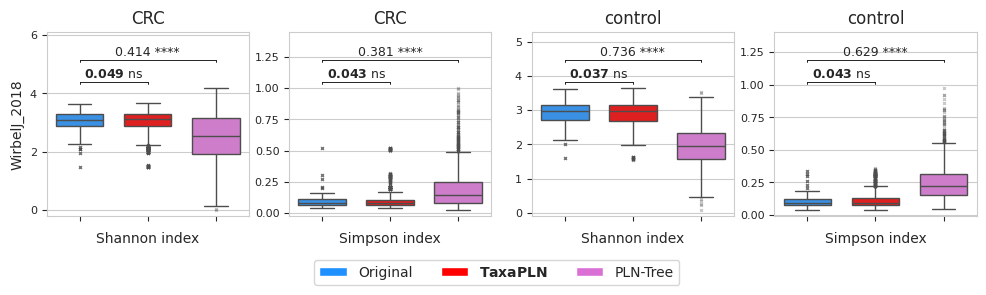

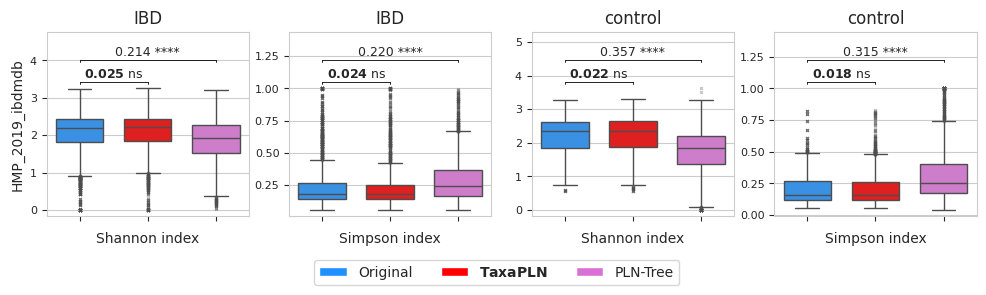

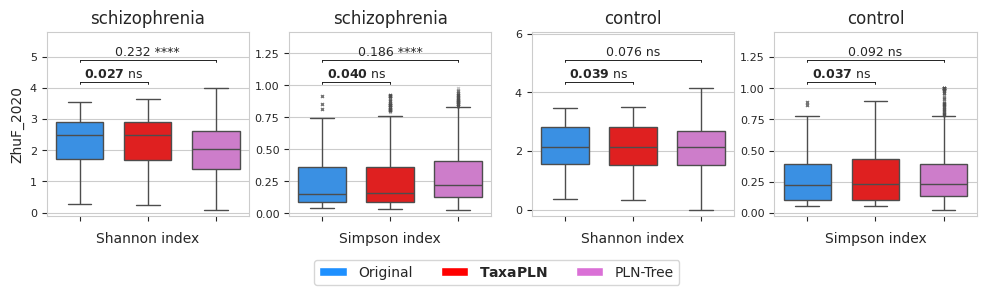

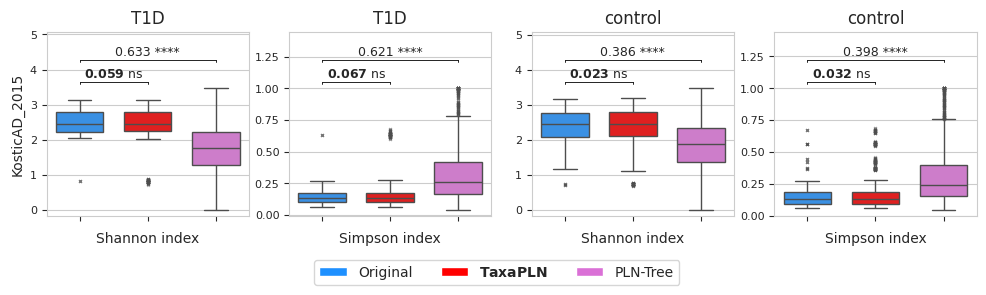

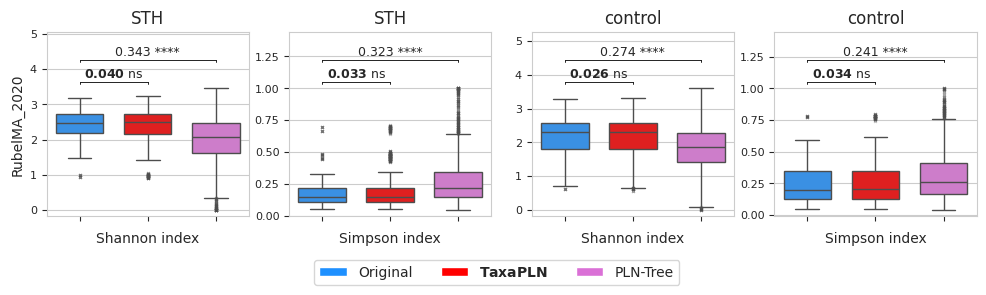

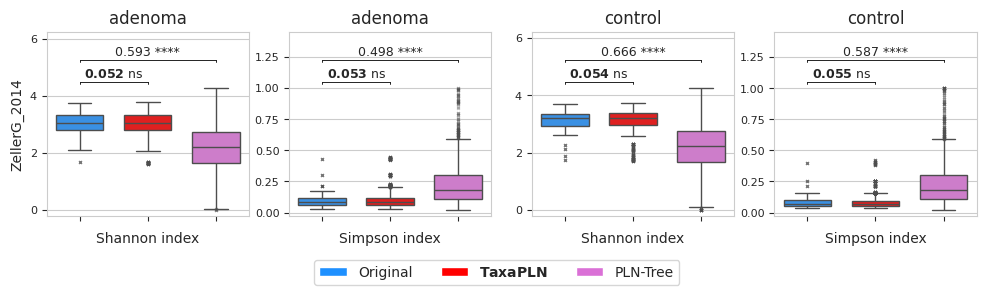

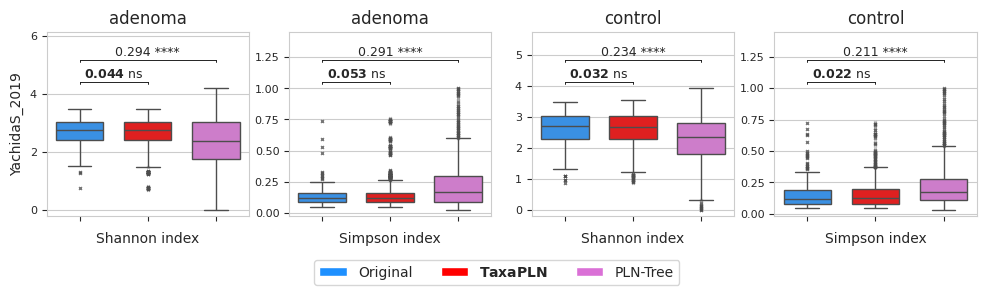

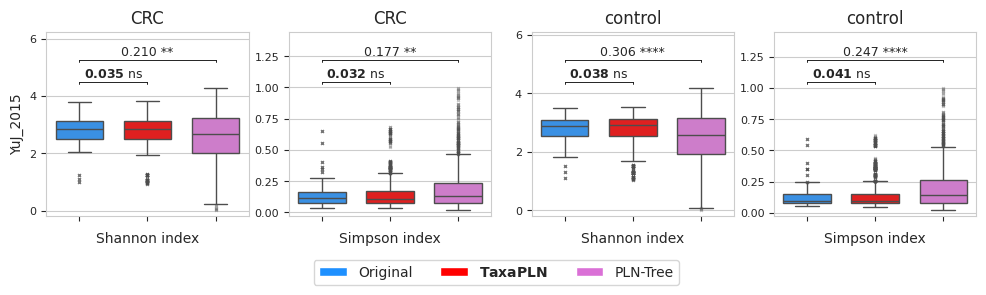

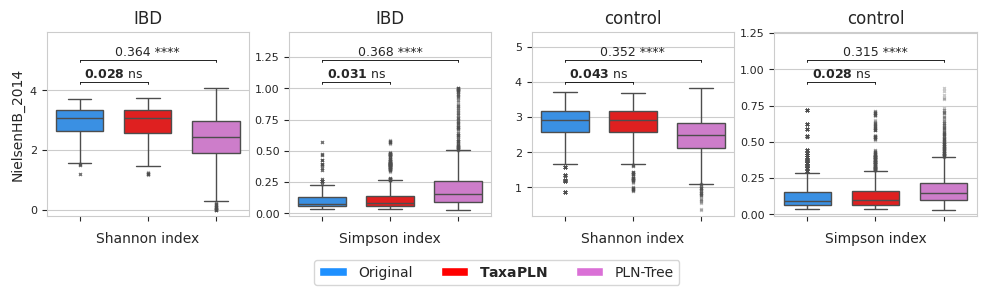

In [16]:
from scipy.stats import ks_2samp, mannwhitneyu
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

alpha_metrics = {
    'Shannon index': shannon_index,
    'Simpson index': simpson_index,
}

pvalues = {
    'Shannon index': {group:[] for group in colors},
    'Simpson index': {group:[] for group in colors},
}

def pvalue_map(pvalue):
    if pvalue <= 0.0001:
        return '****'
    elif pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return 'ns'


for i, study in enumerate(X):
    fig, axs = plt.subplots(1, len(alpha_metrics)*2, figsize=(12, 2.3))
    for j, disease in enumerate(X[study]):
        alpha_div = pd.DataFrame()
        for strategy in X[study][disease]:
            label = strategy if strategy != disease else 'Original'
            X_L = X[study][disease][strategy][:, -1]
            df = pd.DataFrame()
            for metric, metric_fun in alpha_metrics.items():
                df[metric] = metric_fun(X_L)
            df['Group'] = label
            alpha_div = pd.concat((alpha_div, df), ignore_index=True)

        # fixed plotting order: Original first, then others as they appear
        order_groups = ['Original'] + [g for g in alpha_div['Group'].unique() if g != 'Original']

        for k, metric in enumerate(alpha_metrics):
            seed_all(seed)
            ax = axs[j*len(alpha_metrics) + k]

            sns.boxplot(
                data=alpha_div,
                x="Group", y=metric,
                width=0.7, order=order_groups,
                ax=ax, palette=colors,
                showfliers=True,
                flierprops=dict(marker='x', markersize=2, alpha=0.3)
            )

            # KS brackets vs. “Original”
            x_orig   = 0
            vals_orig = alpha_div.loc[alpha_div['Group'] == 'Original', metric]
            
            y0, y1   = ax.get_ylim()
            data_max = alpha_div[metric].max()
            y_range  = y1 - y0
            
            base_offset   = 0.05 * y_range           # first bracket starts 5 % above tallest box
            step_offset   = 0.16 * y_range           # vertical gap between stacked brackets
            tick_height   = 0.015 * y_range          # length of the little vertical ticks
            text_offset   = 0.01 * y_range           # distance between bracket and KS text
            
            # make sure we have enough head-room for all brackets
            n_brackets = len(order_groups) - 1
            top_needed = data_max + base_offset + n_brackets * step_offset
            if top_needed > y1:
                ax.set_ylim(y0, top_needed + 0.05 * y_range) 
            
            ks_vals = []
            for idx, grp in enumerate(order_groups[1:], start=1):             # skip Original
                vals_grp = alpha_div.loc[alpha_div['Group'] == grp, metric]
                ks_stat  = ks_2samp(vals_orig, vals_grp, nan_policy='omit').statistic
                ks_vals.append(ks_stat)
            
            # find the smallest KS so we can bold it later
            ks_min = min(ks_vals)
            
            for idx, (grp, ks_stat) in enumerate(zip(order_groups[1:], ks_vals), start=1):
                vals_grp = alpha_div.loc[alpha_div['Group'] == grp, metric]
                #pvalue = ks_2samp(vals_orig, vals_grp).pvalue
                pvalue = mannwhitneyu(vals_orig, vals_grp, alternative='two-sided', method='auto').pvalue
                pvalues[metric][grp] += [pvalue]
                y_bracket = data_max + base_offset + (idx-1)*step_offset
            
                # horizontal line
                ax.plot([x_orig, idx], [y_bracket, y_bracket], color='k', lw=0.6)
                # vertical ticks
                ax.plot([x_orig, x_orig], [y_bracket, y_bracket - tick_height], color='k', lw=0.6)
                ax.plot([idx, idx],     [y_bracket, y_bracket - tick_height], color='k', lw=0.6)
            
                stat_str = f"{ks_stat:.3f}"
                if ks_stat == ks_min:
                    stat_str = rf"$\bf{{{stat_str}}}$ " + pvalue_map(pvalue)
                else:
                    stat_str = stat_str + ' ' + pvalue_map(pvalue)
            
                ax.text((x_orig + idx)/2,
                        y_bracket + text_offset,
                        stat_str,
                        ha='center', va='bottom', fontsize=9)
            
            ax.set_title(f'{disease}')
            ax.set_ylabel('')
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    axs[0].set_ylabel(study)

    for j, ax in enumerate(axs):
        ax.set_xticklabels([], rotation=-90)
        ax.set_xlabel(list(alpha_metrics.keys())[j % len(alpha_metrics)])
    
    # legend
    handles = [Patch(facecolor=c, label=n if n != 'TaxaPLN' else '$\\bf{TaxaPLN}$') for n, c in colors.items()]
    fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.25),
               ncol=len(handles), frameon=True)
    
    fig.subplots_adjust(bottom=0.08)
    file_name = f'alpha_diversity_benchmark_TaxaPLN_vs_prior_{study}'
    for metric in alpha_metrics.keys():
        file_name = file_name + '_' + metric
    savefig(file_name)

## Data augmentation

We now perform data augmentation. We evaluate TaxaPLN against several state-of-the-art augmentation strategies such as PhyloMix or Compositional Cutmix. The augmentation is performed on 9 datasets using a 25 x 5-Fold CV scheme.

In this section, we visualize the CLR-PCA space of the augmented dataset to see how TaxaPLN explores the microbiome space. Then, we look into appropriate hyperparameter choices such as the augmentation ratio, before performing data augmentation in details at a fixed $\beta=2$ augmentation ratio. Finally, we look into the impact of the training set size through a Hold-Out experiment on the `HMP_2019_ibdmdb` dataset.

In [8]:
from baseline_augmentation import vanilla_mixup, compositional_cutmix, phylomix
import pickle

train_proportion = 0.8
prevalence = 0.15

def get_train_test_dataset(study, n_cv, cov, augment_strategy='None', augment_ratio=3., seed=0):
    """
    Loader for train/test datasets using the cross-validation scheme. 
    It automatically pairs with an augmentation strategy for practability of the pipeline.
    """
    if 'PLN-Tree' in augment_strategy or 'TaxaPLN' in augment_strategy:
        plntree_models = get_plntree(study, n_cv, cov=cov)
        
    dic_data = get_dataset(study, n_cv=n_cv, cov=cov)
    train_test_datasets = [[None for i in range(5)] for j in range(n_cv)]
    for label, disease in enumerate(dic_data):
        for cv, datasets in enumerate(dic_data[disease]):
            for fold, (X_train, cov_train, X_test, cov_test) in enumerate(datasets):
                for ind in X_test.index:
                    if ind in X_train.index:
                        raise ValueError('Data leak in train/test sets.')
                        
                if 'PLN-Tree' in augment_strategy or 'TaxaPLN' in augment_strategy:
                    plntree = plntree_models[disease][cv][fold][0]
                    X_train = X_train[plntree.counts.columns]
                    X_test = X_test[plntree.counts.columns]
                    assert(X_train.columns == plntree.counts.columns).all()
                    assert(X_test.columns == plntree.counts.columns).all()
                
                X_aug = None
                n_aug = int(X_train.shape[0]*(augment_ratio-1))
                if n_aug > 0:
                    if augment_strategy == 'PLN-Tree' or augment_strategy == 'PLN-Tree (cov)':
                        plntree = plntree_models[disease][cv][fold][0]
                        X_aug = plntree.sample(n_aug, seed=seed)[0][:, -1].numpy()
                    elif augment_strategy == 'VampPLN-Tree' or augment_strategy == 'VampPLN-Tree (cov)':
                        if cov:
                            seed_all(seed)
                            plntree = plntree_models[disease][cv][fold][0]
                            cov_ = plntree.covariates
                            indices = np.random.choice(np.arange(0, cov_.shape[0]), size=n_aug, replace=True)
                            cov_sampled = cov_[indices]
                            X_aug = plntree.vamp_sample(
                                covariates=cov_sampled, 
                                seed=seed,
                            )[0][:, -1].numpy()
                        else:
                            X_aug = plntree.vamp_sample(
                                n_samples=n_aug,
                                seed=seed, 
                                mean=False, 
                            )[0][:, -1].numpy()
                    elif augment_strategy == 'PLN' or augment_strategy == 'VampPLN':
                        levels_str = ''
                        for level in levels:
                            levels_str += level
                        prefix_all = save_folder + f'plntreeCV-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'
                        pln_file = prefix_all + f'-PLN0.0.6-{disease}-cv{cv}-{fold}'
                        if os.path.isfile(pln_file):
                            pln = pickle.load(open(pln_file, 'rb'))
                        else:
                            pln = Pln(endog=X_train)
                            pln.fit(verbose=False)
                            pickle.dump(pln, open(pln_file, 'wb'))
                        if augment_strategy == 'PLN':
                            X_aug = sample(pln, n_aug, covariates=None, seed=seed)[0][:, :]
                        else:
                            X_aug = vamp_sample(pln, n_aug)[0][:, :]
                        assert(pln.endog.numpy().shape[0] == X_train.shape[0])
                        X_train = pd.DataFrame(pln.endog.numpy())
                        assert(X_aug.shape[0] == n_aug)
                    elif augment_strategy == 'PLN (cov)' or augment_strategy == 'VampPLN (cov)':
                        levels_str = ''
                        for level in levels:
                            levels_str += level
                        prefix_all = save_folder + f'plntreeCV-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'
                        pln_file = prefix_all + f'-PLNcov-{disease}-cv{cv}-{fold}'
                        if os.path.isfile(pln_file):
                            pln = pickle.load(open(pln_file, 'rb'))
                        else:
                            pln = Pln(endog=X_train, exog=cov_train)
                            pln.fit(verbose=False)
                            pickle.dump(pln, open(pln_file, 'wb'))
                        if augment_strategy == 'PLN':
                            X_aug = sample(pln, n_aug, covariates=None, seed=seed)[0][:, :]
                        else:
                            X_aug = vamp_sample(pln, n_aug)[0][:, :]
                    elif augment_strategy == 'vanilla-mixup':
                        X_aug = vanilla_mixup(X_train.to_numpy(), n_aug)
                    elif augment_strategy == 'compositional-cutmix':
                        X_aug = compositional_cutmix(X_train.to_numpy(), n_aug, normalize=False)
                    elif 'PhyloMix' in augment_strategy:
                        X_aug = phylomix(X_train, n_aug, tree='taxonomy', clr='CLR' in augment_strategy).to_numpy()
                    elif augment_strategy == 'None':
                        X_aug = None
                    else:
                        raise ValueError(f'Strategy {augment_strategy} was not found.')
                
                
                if X_aug is not None:
                    assert not np.isnan(X_aug).any(), "Generated data contains a NaN."
                    assert X_aug.shape[0] == n_aug, "Generated data does not match the amount of augmentation asked for."
                    X_train_disease = np.concatenate((X_train.to_numpy(), X_aug))
                else:
                    X_train_disease = X_train.to_numpy()
    
                y_train_disease = np.ones(X_train_disease.shape[0]) * label
                y_test_disease = np.ones(X_test.shape[0]) * label
                        
                if train_test_datasets[cv][fold] == None:
                    train_test_datasets[cv][fold] = [X_train_disease, y_train_disease, X_test.to_numpy(), y_test_disease]
                else:
                    train_test_datasets[cv][fold] = [
                        np.concatenate((train_test_datasets[cv][fold][0], X_train_disease)),
                        np.concatenate((train_test_datasets[cv][fold][1], y_train_disease)),
                        np.concatenate((train_test_datasets[cv][fold][2], X_test.to_numpy())),
                        np.concatenate((train_test_datasets[cv][fold][3], y_test_disease))
                    ]
    return train_test_datasets

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC

def get_classifier(classifier_type):
    """
    Parameters loader and object for each classifier considered in our experiments
    """
    if classifier_type == 'logreg':
        classifier = LogisticRegression
        classifier_params = {}
    elif classifier_type == 'RF':
        classifier = RandomForestClassifier
        classifier_params = {}
    elif classifier_type == 'XGBoost':
        classifier = GradientBoostingClassifier
        classifier_params = {'learning_rate': 0.05}
    elif classifier_type == 'svm':
        classifier = LinearSVC
        classifier_params = {}
    elif classifier_type == 'svm_rbf':
        classifier = SVC
        classifier_params = {}
    elif classifier_type == 'mlp':
        classifier = MLPClassifier
        classifier_params = {'hidden_layer_sizes':(256, 128), 'solver':'adam', 'max_iter':200}
    return classifier, classifier_params

In [10]:
def clr(X):
    """
    CLR transform preprocessing
    """
    if (X < 0).any():
        print(X[X < 0])
        assert not (X < 0).any(), "Data contains negative entries and can not be CLR transformed."
    log_X = np.log(X + .5)
    assert not np.isnan(log_X).any(), "Log on data contains a NaN."
    clr_X = log_X - np.mean(log_X, axis=1, keepdims=True)
    return clr_X

def proportion(X):
    """
    Relative abundance preprocessing
    """
    X_rel = X / (X.sum(-1, keepdims=True) + 1e-32)
    if np.abs(X_rel.sum(-1).max() - 1) > 1e-8:
        raise ValueError(f'Proportion transform is not compositional: max={X_rel.sum(-1).max()}, min={X_rel.sum(-1).min()}, mean={X_rel.sum(-1).mean()}')
    return X_rel

def augmented_classifiers(disease, classifier_type, train_test_datasets, preprocessing=None, seed=0):
    """
    Performs training of a classifier on a given augmented train/test dataset with given preprocessing.
    """
    classifier, params = get_classifier(classifier_type)
    wrapper = [[] for i in range(len(train_test_datasets))]
    levels_str = ''
    for level in levels:
        levels_str += level
    prefix_all = save_folder + f'plntreeCV-LV{levels_str}-prev{prevalence}-s{seed}'
    for cv in range(len(train_test_datasets)):
        for fold, (X_train, y_train, X_test, y_test) in enumerate(train_test_datasets[cv]):
            seed_all(seed)
            if preprocessing == 'clr':
                fold_file = prefix_all + f'-predictions-{disease}-cv{cv}-{fold}.csv'
            else:
                fold_file = prefix_all + f'-{preprocessing}-predictions-{disease}-cv{cv}-{fold}.csv'
            try:
                results = pd.read_csv(fold_file)
                assert (y_test == results['test'].to_numpy()).all()
                y_pred = results['prediction']
            except:
                print('     - Learning classifier: ' + fold_file)
                assert classifier_type in fold_file, f'[Error] About to train {classifier_type} onto {disease}.'
                assert len(np.unique(y_train)) == 2
                assert len(np.unique(y_test)) == 2
                indices_train = np.arange(0, y_train.shape[0], 1)
                np.random.shuffle(indices_train)
                if preprocessing == 'clr':
                    preprocessing_fun = clr
                elif preprocessing == 'proportion':
                    preprocessing_fun = proportion
                elif preprocessing == 'none':
                    preprocessing = lambda x: x
                else:
                    raise ValueError('Preprocessing was not specified')
                X_train_prec = preprocessing_fun(X_train)
                X_test_prec = preprocessing_fun(X_test)
                assert not np.isnan(X_train_prec).any(), "Preprocessed training data contains a NaN."
                assert not np.isnan(X_test_prec).any(), "Preprocessed test data contains a NaN."
                model = classifier(**params).fit(X_train_prec[indices_train], y_train[indices_train])
                try:
                    y_pred = model.predict_proba(X_test_prec)[:, 1]
                except:
                    y_pred = model.decision_function(X_test_prec)
                results = pd.DataFrame()
                results['test'] = y_test
                results['prediction'] = y_pred
                results.to_csv(fold_file, index=False)
            wrapper[cv].append((results['prediction'], results['test']))
    return wrapper

def evaluate_classifiers(wrapper, metric=average_precision_score):
    """
    Evaluate the output of augmented_classifier function given the metric.
    """
    metrics = []
    for cv in range(len(wrapper)):
        metrics_fold = 0.
        for fold, (y_pred, y_test) in enumerate(wrapper[cv]):
            metrics_fold += metric(y_test, y_pred) / len(wrapper[cv])
        metrics.append(metrics_fold)
    return np.array(metrics)

### Beta diversity benchmark

Before evaluating the classification gains, we explore the impact of the augmentation on the feature space. In particular, using a Aitchison diversity (CLR-PCA) and Bray-Curtis diversity, we would like to assess how TaxaPLN explores the space of microbiome samples. 

In [11]:
augment_ratio = 2.
strategies = [
    'None',
    'vanilla-mixup',
    'compositional-cutmix',
    'PhyloMix',
    'PLN',
    # 'PLN-Tree',
    'VampPLN-Tree',
]
n_cv = 1

# Prepare the datasets for the CLR-PCA representation
datasets_studies = {}
for study in data.keys():
    print(study, ':')
    datasets_studies[study] = {strategy:[] for strategy in strategies}
    for strategy in strategies:
        train_test_datasets = get_train_test_dataset(
            study, 
            n_cv, cov='(cov)' in strategy, 
            augment_strategy=strategy, 
            augment_ratio=augment_ratio, 
            seed=seed
        )
        X_ = None
        y_ = None
        for cv in range(len(train_test_datasets)):
            for fold, (X_train, y_train, X_test, y_test) in enumerate(train_test_datasets[cv]):
                X_ = X_train if X_ is None else np.concatenate((X_, X_train))
                y_ = y_train if y_ is None else np.concatenate((y_, y_train))
        datasets_studies[study][strategy] = (X_, y_)
        print('  *', strategy, 'composition:', np.unique(y_, return_counts=True))

WirbelJ_2018 :
  * None composition: (array([0., 1.]), array([240, 260]))
  * vanilla-mixup composition: (array([0., 1.]), array([480, 520]))
  * compositional-cutmix composition: (array([0., 1.]), array([480, 520]))
  * PhyloMix composition: (array([0., 1.]), array([480, 520]))
  * PLN composition: (array([0., 1.]), array([480, 520]))
  * VampPLN-Tree composition: (array([0., 1.]), array([480, 520]))
HMP_2019_ibdmdb :
  * None composition: (array([0., 1.]), array([3732, 1364]))
  * vanilla-mixup composition: (array([0., 1.]), array([7464, 2728]))
  * compositional-cutmix composition: (array([0., 1.]), array([7464, 2728]))
  * PhyloMix composition: (array([0., 1.]), array([7464, 2728]))
  * PLN composition: (array([0., 1.]), array([7464, 2728]))
  * VampPLN-Tree composition: (array([0., 1.]), array([7464, 2728]))
ZhuF_2020 :
  * None composition: (array([0., 1.]), array([360, 324]))
  * vanilla-mixup composition: (array([0., 1.]), array([720, 648]))
  * compositional-cutmix composition

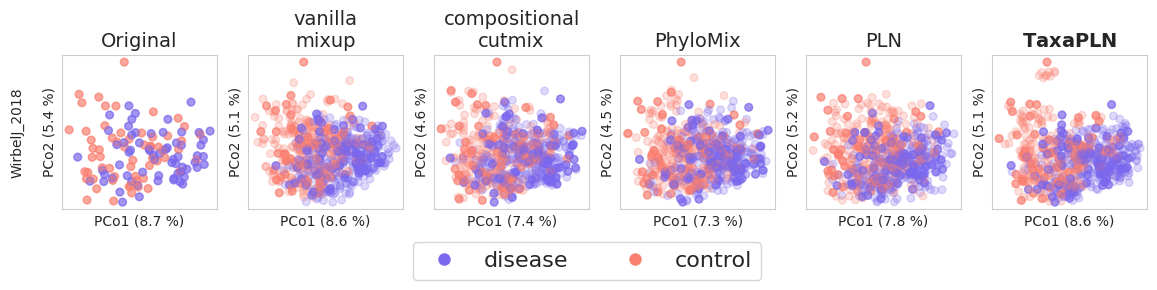

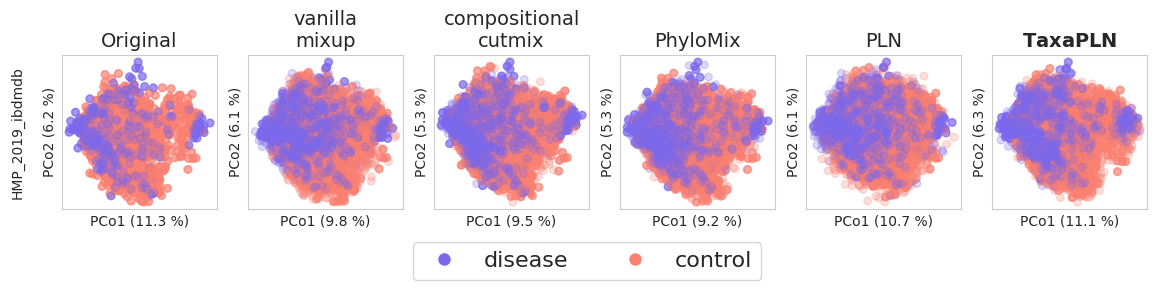

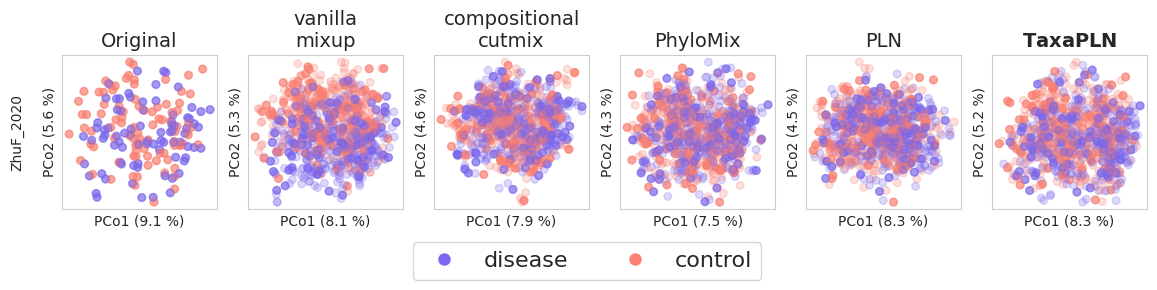

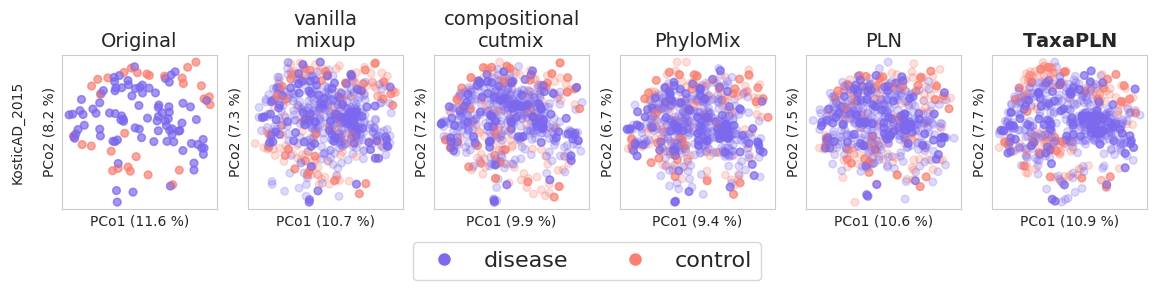

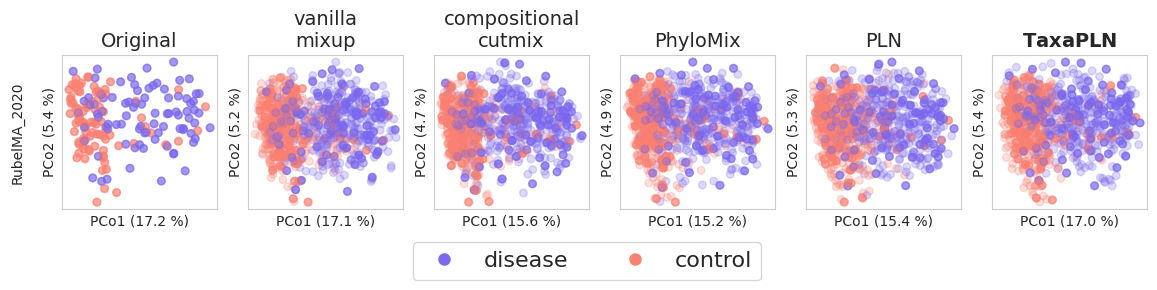

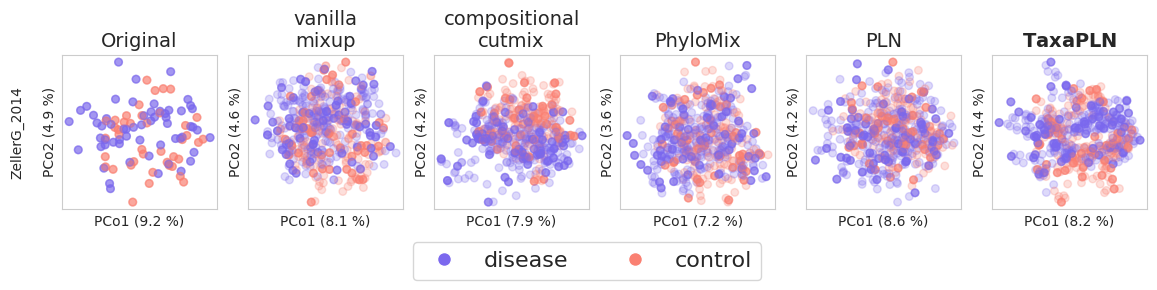

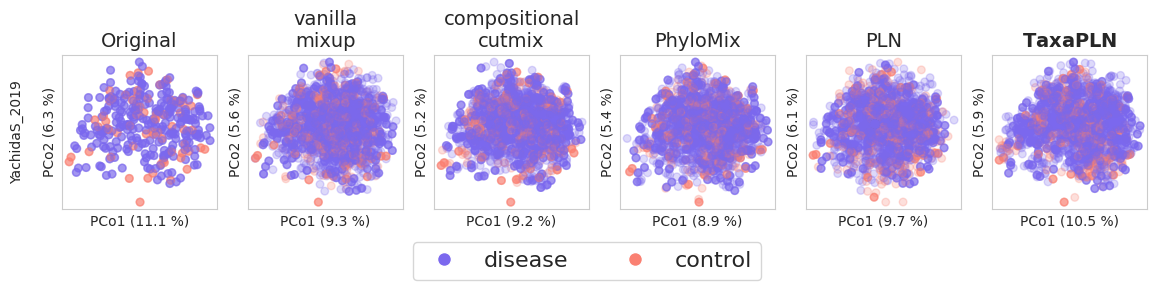

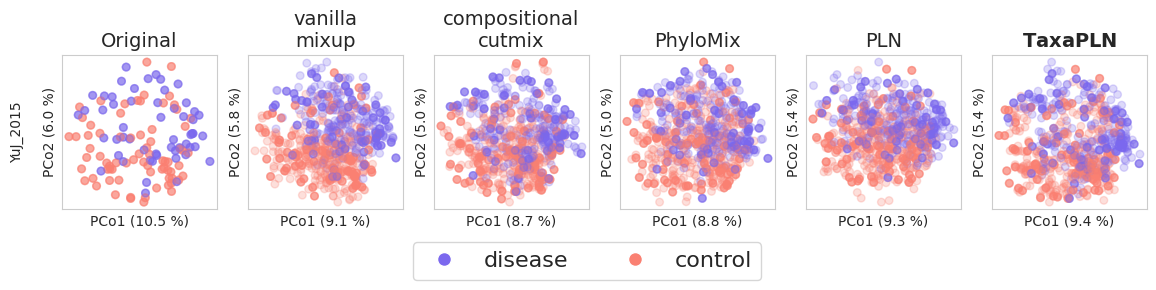

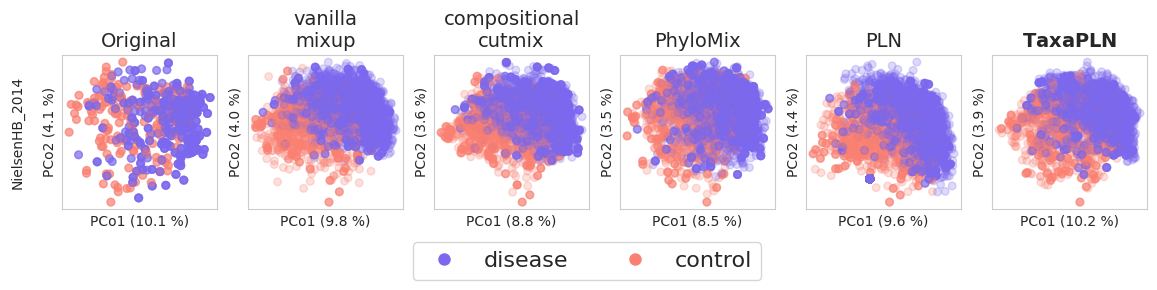

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from matplotlib.lines import Line2D

def _align_pcoa_signs(target, reference, axes=('PC1', 'PC2')):
    """
    Flip each axis of `target` so it correlates positively with `reference`.
    """
    common = target.samples.index.intersection(reference.samples.index)
    if len(common) < 2:          # nothing to align
        return target

    for ax in axes:
        r = np.corrcoef(target.samples.loc[common, ax],
                        reference.samples.loc[common, ax])[0, 1]
        if r < 0:                # negative correlation -> flip axis
            target.samples[ax] *= -1
    return target


def plot_beta_diversity_pcoa(
        diversity,
        X_, y_,
        ref_pcoa=None,                   # <- NEW
        label_names=('class 0', 'class 1'),
        colors=('#3182bd', '#e6550d'),
        figsize=(6, 5),
        point_size=30,
        ax=None,
        return_pcoa=False,               # <- NEW
        scatter_kw={}):
    """
    Display Bray-Curtis or Aitchison PCoA plot.
    If `ref_pcoa` is provided, the two first axes are sign-aligned
    to it so that plots are oriented the same way.
    """
    X_ = np.asarray(X_, dtype=float)
    y_ = np.asarray(y_)
    assert set(np.unique(y_)) <= {0, 1}, f"y must contain only 0 and 1. Current values: {set(np.unique(y_))}"

    if diversity == 'braycurtis':
        X_rel = (X_ + 1e-32) / (X_ + 1e-32).sum(-1, keepdims=True)
        dm = beta_diversity('braycurtis', X_rel)
    elif diversity == 'aitchison':
        X_log = np.log(X_ + 1e-32)
        X_clr = X_log - X_log.mean(axis=-1, keepdims=True)
        dm = beta_diversity('euclidean', X_clr, validate=False)
    else:
        raise ValueError("diversity must be 'braycurtis' or 'aitchison'")

    pcoa_res = pcoa(dm, number_of_dimensions=2, method='fsvd', seed=seed)

    # optional alignment to reference ordination
    if ref_pcoa is not None:
        pcoa_res = _align_pcoa_signs(pcoa_res, ref_pcoa)

    pcoa_df = pcoa_res.samples
    pcoa_df['Group'] = y_
    pcoa_df['Color'] = [colors[int(lbl)] for lbl in y_]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(pcoa_df['PC1'], pcoa_df['PC2'],
               c=pcoa_df['Color'], alpha=.25, s=point_size, **scatter_kw)

    ax.set_xlabel(f"PCo1 ({pcoa_res.proportion_explained[0]*100:.1f} %)")
    ax.set_ylabel(f"PCo2 ({pcoa_res.proportion_explained[1]*100:.1f} %)")
    ax.grid(False)

    return (ax, pcoa_res) if return_pcoa else ax




diversity = 'aitchison'       # Either 'braycurtis' or 'aitchison'
sns.set_style('whitegrid')

for study in data.keys():
    fig, axs = plt.subplots(1, len(strategies), figsize=(14, 2)) # Put (8,2) for figsize of TaxaPLNvsPLN-Tree files, (14, 2) otherwise

    ref_pcoa = None            # will hold the ordination of the 'None' strategy

    for j, (strategy, (X_, y_)) in enumerate(datasets_studies[study].items()):
        ax, this_pcoa = plot_beta_diversity_pcoa(
            diversity, X_, y_,
            ref_pcoa=ref_pcoa,
            ax=axs[j],
            colors=('salmon', 'mediumslateblue'),
            label_names=data[study],
            return_pcoa=True
        )

        if strategy == 'None':
            ref_pcoa = this_pcoa 

        axs[j].set_xticks([])
        axs[j].set_yticks([])

        if   strategy == 'None':        strategy_name = 'Original'
        elif strategy == 'VampPLN-Tree':strategy_name = r'$\bf{TaxaPLN}$'
        elif strategy == 'VampPLN':     strategy_name = 'PLN'
        else:                           strategy_name = strategy
        axs[j].set_title(
            strategy_name.replace('-', '\n'), # remove the 'replace' for TaxaPLNvsPLN-Tree files
            size=14
        ) 

    axs[0].set_ylabel(f'{study}\n\n' + axs[0].get_ylabel())

    custom_lines = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor='mediumslateblue', markersize=10),
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor='salmon', markersize=10)
    ]
    fig.legend(custom_lines, ['disease', 'control'],
               loc='lower center', ncol=2, fontsize=16,
               frameon=True, bbox_to_anchor=(0.5, -0.3))

    savefig(f'{diversity}-PCoA-{study}', 'jpg', 350) # Add the '-TaxaPLNvsPLN-Tree' suffix for this comparison when needed

### Choice of augmentation ratio

We look into the impact of the augmentation ratio $\beta$ on the performance of downstream classifiers.

In [25]:
augment_ratios = [1.0, 2.0, 3.0, 4.0, 5.0]  # Augmentation ratios to test
preprocessing = 'clr' # preprocessing, 'clr' or 'proportion'
classifier_types = ['RF', 'mlp', 'XGBoost', 'logreg'] # Evaluated models
strategy = 'VampPLN-Tree' # Strategy of interest
n_cv = 25

levels_str = ''
for level in levels:
    levels_str += level
prefix_file = save_folder + f'plntreeCV-LV{levels_str}-prev{prevalence}-s{seed}'
classifiers_perfs = {}
for classifier_type in classifier_types:
    print(classifier_type, ':')
    beta_perfs = {}
    for study in data.keys():
        print('  ', study, ':')
        beta_perfs[study] = []
        for augment_ratio in augment_ratios:
            seed_all(seed)
            filetag = f'{study}_{strategy}_{classifier_type}_{augment_ratio}'
            fold_file = prefix_file + f'-predictions-{filetag}-cv{n_cv-1}-4.csv'
            train_test_datasets = get_train_test_dataset(
                study, 
                n_cv, cov='(cov)' in strategy, 
                augment_strategy='None' if os.path.isfile(fold_file) else strategy, 
                augment_ratio=augment_ratio, 
                seed=seed
            )
            wrapper = augmented_classifiers(
                filetag, 
                classifier_type, 
                train_test_datasets, 
                preprocessing=preprocessing, 
                seed=seed,
            )
            scores = evaluate_classifiers(wrapper, metric=average_precision_score)
            beta_perfs[study].append(scores)
            print('      *', strategy, "at beta =", augment_ratio ,": AUPRC", np.round(scores.mean()*100, 1), f'({np.round(scores.std()*100, 1)})')
    classifiers_perfs[classifier_type] = beta_perfs

RF :
   WirbelJ_2018 :
      * VampPLN-Tree at beta = 1.0 : AUPRC 85.2 (1.8)
      * VampPLN-Tree at beta = 2.0 : AUPRC 86.4 (1.6)
      * VampPLN-Tree at beta = 3.0 : AUPRC 86.7 (1.7)
      * VampPLN-Tree at beta = 4.0 : AUPRC 86.8 (1.6)
      * VampPLN-Tree at beta = 5.0 : AUPRC 87.0 (1.7)
   HMP_2019_ibdmdb :
      * VampPLN-Tree at beta = 1.0 : AUPRC 96.4 (0.2)
      * VampPLN-Tree at beta = 2.0 : AUPRC 97.8 (0.2)
      * VampPLN-Tree at beta = 3.0 : AUPRC 98.1 (0.2)
      * VampPLN-Tree at beta = 4.0 : AUPRC 98.2 (0.2)
      * VampPLN-Tree at beta = 5.0 : AUPRC 98.3 (0.2)
   ZhuF_2020 :
      * VampPLN-Tree at beta = 1.0 : AUPRC 80.1 (2.4)
      * VampPLN-Tree at beta = 2.0 : AUPRC 81.2 (2.6)
      * VampPLN-Tree at beta = 3.0 : AUPRC 80.7 (2.6)
      * VampPLN-Tree at beta = 4.0 : AUPRC 81.2 (2.4)
      * VampPLN-Tree at beta = 5.0 : AUPRC 81.8 (2.0)
   KosticAD_2015 :
      * VampPLN-Tree at beta = 1.0 : AUPRC 95.4 (1.1)
      * VampPLN-Tree at beta = 2.0 : AUPRC 95.7 (0.7)
    

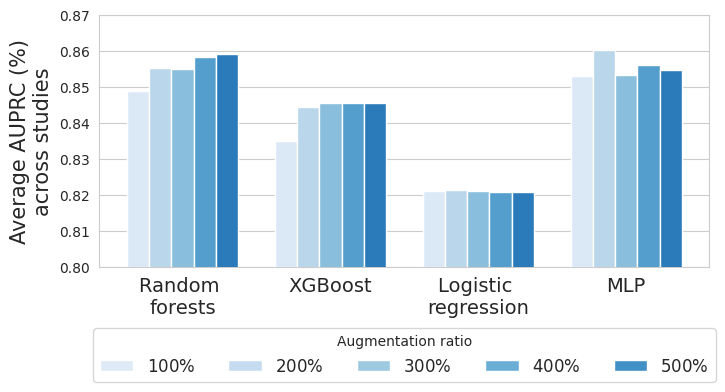

In [26]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

# Plot of the average performance across all studies for the various classifiers

df_all = pd.DataFrame()
for classifier_type in classifiers_perfs:
    perfs_mean = []
    for i, beta in enumerate(augment_ratios):
        perfs_mean_studies = [] 
        for study in beta_perfs:
            perfs_mean_studies.append(np.array(classifiers_perfs[classifier_type][study])[i])
        perfs_mean.append(np.array(perfs_mean_studies).mean(axis=1))
    perfs_mean = np.array(perfs_mean)
    
    df = pd.DataFrame(data=perfs_mean)
    df.columns = list(data.keys())
    df['Beta'] = augment_ratios
    df['Group'] = classifier_type
    df_all = pd.concat((df_all, df), ignore_index=True)

df_all = df_all.transpose()
meta = df_all.loc[['Beta', 'Group']]             
perf = df_all.drop(index=['Beta', 'Group']) 
perf = perf.astype(float)              

beta_lv = meta.loc['Beta'].astype(int)           
group_lv = meta.loc['Group']                      
perf.columns = pd.MultiIndex.from_arrays(
    [beta_lv, group_lv],
    names=['Beta', 'Group']
)

mean_by_bg = (
    perf
    .mean(axis=0)                
    .unstack('Group')             
    .sort_index()                
)
std_by_bg = (
    perf
    .std(axis=0)                
    .unstack('Group')             
    .sort_index()                 
)

fig, ax = plt.subplots(figsize=(9/1.2, 5/1.2))

w = 0.6
x         = np.linspace(1, 1 + w, len(mean_by_bg))              
width     = w / len(mean_by_bg.columns)              # bar width so clusters don’t overlap

for i, grp in enumerate(mean_by_bg.columns):
    ax.bar(x + i,
           mean_by_bg[grp].values,
           width=width,
           color=[cm.Blues((j+1)/(len(mean_by_bg.columns)+3)) for j in range(len(mean_by_bg[grp].values))],
           zorder=10
           )
legend_handles = [
    Patch(facecolor=cm.Blues((j+1)/(len(mean_by_bg)+3)), label=f'${np.round(beta*100)}\%$')
    for j, beta in enumerate(mean_by_bg.index)
]
ax.legend(handles=legend_handles, title=r'Augmentation ratio',
          loc='upper center', bbox_to_anchor=(0.5, -0.21), fontsize=12,
          ncol=len(mean_by_bg), frameon=True)
groups = np.array(list(mean_by_bg.columns)).astype('U32')
for group in groups:
    if group == 'RF':
        groups[groups == group] = 'Random \nforests'
    elif group == 'logreg':
        groups[groups == group] = 'Logistic \nregression'
    elif group == 'mlp':
        groups[groups == group] = 'MLP'
    elif group == 'svm':
        groups[groups == group] = 'Linear SVM'
    elif group == 'svm_rbf':
        groups[groups == group] = 'RBF SVM'
    elif group == 'XGBoost':
        groups[groups == group] = 'XGBoost'
#ax.set_xticks(ax.get_xticks()[1:-1]+0.3)
ax.set_xticks([x.mean()+i for i in range(len(groups))])
ax.set_xticklabels(groups, size=14)
#ax.set_xticklabels(mean_by_bg.index)
ax.set_ylabel('Average AUPRC (%)\nacross studies', size=15)
ax.set_ylim(0.8, 0.87)
ax.grid(False)
ax.grid(axis='y', zorder=0)
plt.tight_layout()
savefig(f'Choice_augmentation_ratio_CV_{strategy}')

### Augmentation benchmark

We perform the data augmentation benchmark at $\beta=2$. We test several classifiers on our 9 datasets.

In [39]:
import os

# Restate of the datasets, for faster modifications
data = {
    'WirbelJ_2018': ['CRC', 'control'],
    'KosticAD_2015': ['T1D', 'control'],
    'RubelMA_2020': ['STH', 'control'],
    'ZhuF_2020': ['schizophrenia', 'control'],
    'ZellerG_2014': ['adenoma', 'control'], 
    'YachidaS_2019': ['adenoma', 'control'],
    'YuJ_2015': ['CRC', 'control'],
    'NielsenHB_2014': ['IBD', 'control'],
    'HMP_2019_ibdmdb': ['IBD', 'control'],
}

augment_ratio = 2. # Beta value
preprocessing = 'clr' # One in ['clr', 'proportion']
classifier_type = 'XGBoost' # One in ['RF', 'mlp', 'logreg', 'XGBoost', 'svm_rbf', 'svm']
strategies = [
    'None',
    'VampPLN-Tree',
    'VampPLN',
    'vanilla-mixup',
    'compositional-cutmix',
    'PhyloMix',
]
n_cv = 25


levels_str = ''
for level in levels:
    levels_str += level
prefix_file = save_folder + f'plntreeCV-LV{levels_str}-prev{prevalence}-s{seed}'
perfs_study = {}
for study in data.keys():
    print(study, ':')
    perfs_study[study] = {strategy:[] for strategy in strategies}
    for strategy in strategies:
        seed_all(seed)
        filetag = f'{study}_{strategy}_{classifier_type}_{augment_ratio}'
        if preprocessing == 'clr':
            fold_file = prefix_file + f'-predictions-{filetag}-cv{n_cv-1}-4.csv'
        else:
            fold_file = prefix_file + f'-{preprocessing}-predictions-{filetag}-cv{n_cv-1}-4.csv'
        train_test_datasets = get_train_test_dataset(
                study, 
                n_cv, cov='(cov)' in strategy, 
                augment_strategy='None' if os.path.isfile(fold_file) else strategy, 
                augment_ratio=augment_ratio, 
                seed=seed
            )
        wrapper = augmented_classifiers(
            filetag, 
            classifier_type, 
            train_test_datasets, 
            preprocessing=preprocessing, 
            seed=seed,
        )
        scores = evaluate_classifiers(wrapper, metric=average_precision_score)
        perfs_study[study][strategy] = wrapper #scores
        print('   *', strategy, ': AUPRC', np.round(scores.mean()*100, 1), f'({np.round(scores.std()*100, 1)})')

WirbelJ_2018 :
   * None : AUPRC 81.8 (2.8)
   * VampPLN-Tree : AUPRC 81.9 (3.4)
   * VampPLN : AUPRC 82.6 (3.3)
   * vanilla-mixup : AUPRC 83.5 (3.1)
   * compositional-cutmix : AUPRC 83.5 (3.1)
   * PhyloMix : AUPRC 83.7 (2.4)
KosticAD_2015 :
   * None : AUPRC 95.4 (1.0)
   * VampPLN-Tree : AUPRC 95.6 (0.8)
   * VampPLN : AUPRC 95.6 (1.5)
   * vanilla-mixup : AUPRC 95.5 (1.0)
   * compositional-cutmix : AUPRC 95.6 (1.3)
   * PhyloMix : AUPRC 95.5 (1.3)
RubelMA_2020 :
   * None : AUPRC 82.7 (2.0)
   * VampPLN-Tree : AUPRC 82.6 (2.3)
   * VampPLN : AUPRC 82.2 (1.4)
   * vanilla-mixup : AUPRC 83.0 (1.9)
   * compositional-cutmix : AUPRC 83.1 (1.9)
   * PhyloMix : AUPRC 83.3 (1.5)
ZhuF_2020 :
   * None : AUPRC 76.7 (3.1)
   * VampPLN-Tree : AUPRC 78.7 (2.9)
   * VampPLN : AUPRC 78.6 (2.6)
   * vanilla-mixup : AUPRC 76.9 (2.3)
   * compositional-cutmix : AUPRC 75.8 (2.8)
   * PhyloMix : AUPRC 77.3 (3.0)
ZellerG_2014 :
   * None : AUPRC 68.3 (3.9)
   * VampPLN-Tree : AUPRC 68.8 (3.7)
   * 

In [40]:
metric = average_precision_score
metric_study = {
    scenario:{
        strategy:evaluate_classifiers(wrapper, metric=metric) for strategy, wrapper in wrapper_strategies.items()
    } for scenario, wrapper_strategies in perfs_study.items()
}
per_scenario_mean_gain = {}
per_scenario_mean_std = {}
per_scenario_mean_gain = pd.DataFrame()
per_scenario_mean_std = pd.DataFrame()
for scenario in data:
    data_perf = pd.DataFrame(metric_study[scenario])[strategies]
    per_scenario_mean_gain[scenario] = data_perf.mean(axis=0)
    per_scenario_mean_std[scenario] = data_perf.std(axis=0)
per_scenario_mean_gain = per_scenario_mean_gain*100
per_scenario_mean_std = per_scenario_mean_std*100
per_scenario_mean_gain = per_scenario_mean_gain.loc[per_scenario_mean_gain.mean(axis=1).sort_values(ascending=False).index]
per_scenario_mean_std = per_scenario_mean_std.loc[per_scenario_mean_gain.mean(axis=1).sort_values(ascending=False).index]


merged_df = per_scenario_mean_gain.applymap(lambda x: f"{x:.1f}") \
            + " (" + per_scenario_mean_std.applymap(lambda x: f"{x:.1f}") + ")"
merged_df['Avg gain'] = (per_scenario_mean_gain.mean(axis=1) - per_scenario_mean_gain.loc['None'].mean()).apply(lambda x: f"{x:.2f}")

print('VampPLN-Tree mean gains per dataset:\n')
print((per_scenario_mean_gain - per_scenario_mean_gain.loc['None']).applymap(lambda x: f"{x:.1f}%").transpose())

merged_df.transpose()

VampPLN-Tree mean gains per dataset:

                VampPLN-Tree PhyloMix compositional-cutmix vanilla-mixup  \
WirbelJ_2018            0.1%     1.9%                 1.6%          1.6%   
KosticAD_2015           0.1%     0.1%                 0.2%          0.1%   
RubelMA_2020           -0.1%     0.6%                 0.4%          0.3%   
ZhuF_2020               2.0%     0.5%                -1.0%          0.1%   
ZellerG_2014            0.5%     0.8%                 1.7%          0.8%   
YachidaS_2019           2.6%     2.0%                 1.3%          1.7%   
YuJ_2015                1.8%     1.1%                 0.6%         -2.5%   
NielsenHB_2014          0.4%     0.1%                 0.2%          0.0%   
HMP_2019_ibdmdb         0.2%    -0.6%                -0.8%          0.6%   

                VampPLN  None  
WirbelJ_2018       0.8%  0.0%  
KosticAD_2015      0.2%  0.0%  
RubelMA_2020      -0.5%  0.0%  
ZhuF_2020          1.9%  0.0%  
ZellerG_2014      -1.1%  0.0%  
YachidaS_

VampPLN-Tree    PhyloMix compositional-cutmix vanilla-mixup  \
WirbelJ_2018      81.9 (3.5)  83.7 (2.4)           83.5 (3.2)    83.5 (3.2)   
KosticAD_2015     95.6 (0.8)  95.5 (1.4)           95.6 (1.4)    95.5 (1.1)   
RubelMA_2020      82.6 (2.4)  83.3 (1.5)           83.1 (2.0)    83.0 (2.0)   
ZhuF_2020         78.7 (3.0)  77.3 (3.1)           75.8 (2.8)    76.9 (2.4)   
ZellerG_2014      68.8 (3.8)  69.1 (3.9)           70.0 (3.5)    69.1 (4.1)   
YachidaS_2019     81.4 (1.6)  80.8 (1.6)           80.1 (1.9)    80.5 (1.7)   
YuJ_2015          77.9 (4.1)  77.2 (3.6)           76.8 (2.8)    73.7 (4.2)   
NielsenHB_2014    97.5 (0.3)  97.2 (0.3)           97.3 (0.3)    97.2 (0.5)   
HMP_2019_ibdmdb   95.5 (0.5)  94.8 (0.5)           94.6 (0.4)    96.0 (0.4)   
Avg gain                0.84        0.71                 0.48          0.32   

                    VampPLN        None  
WirbelJ_2018     82.6 (3.4)  81.8 (2.8)  
KosticAD_2015    95.6 (1.5)  95.4 (1.0)  
RubelMA_2020     82.2 (1.5)  82.7 (2.0)  
ZhuF_2020        78.6 (2.7)  76.7 (3.2)  
ZellerG_2014     67.2 (3.4)  68.3 (4.0)  
YachidaS_2019    80.1 (1.7)  78.8 (1.4)  
YuJ_2015         75.8 (3.6)  76.2 (4.1)  
NielsenHB_2014   97.2 (0.3)  97.1 (0.5)  
HMP_2019_ibdmdb  95.6 (0.4)  95.4 (0.3)  
Avg gain               0.28        0.00

In [41]:
import pandas as pd
import scipy.stats as stats

target = 'VampPLN-Tree'
others = [s for s in strategies if s != target]
p_values = pd.DataFrame(columns=others)

test = 't-test'

for scenario in data:
    data_perf = pd.DataFrame(metric_study[scenario])[strategies]
    target_data = data_perf[target]
    p_values_per_strategy = {}
    for strategy in others:
        d = target_data - data_perf[strategy]
        if test == 't-test':
            t_stat, p_val = stats.ttest_rel(target_data, data_perf[strategy], alternative='greater')
        elif test == 'wilcoxon':
            stat, p_val = stats.wilcoxon(target_data, data_perf[strategy], zero_method="pratt", alternative="greater")
        p_values_per_strategy[strategy] = p_val
    p_values.loc[scenario] = p_values_per_strategy


def signifiance(p):
    if p <= 0.0001:
        return '****'
    elif p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return 'ns'
p_sig = p_values.applymap(signifiance)
p_sig

None VampPLN vanilla-mixup compositional-cutmix PhyloMix
WirbelJ_2018       ns      ns            ns                   ns       ns
KosticAD_2015      ns      ns            ns                   ns       ns
RubelMA_2020       ns      ns            ns                   ns       ns
ZhuF_2020          **      ns            **                 ****        *
ZellerG_2014       ns       *            ns                   ns       ns
YachidaS_2019    ****      **             *                  ***        *
YuJ_2015          ***      **          ****                    *       ns
NielsenHB_2014   ****     ***            **                   **      ***
HMP_2019_ibdmdb    ns      ns            ns                 ****     ****

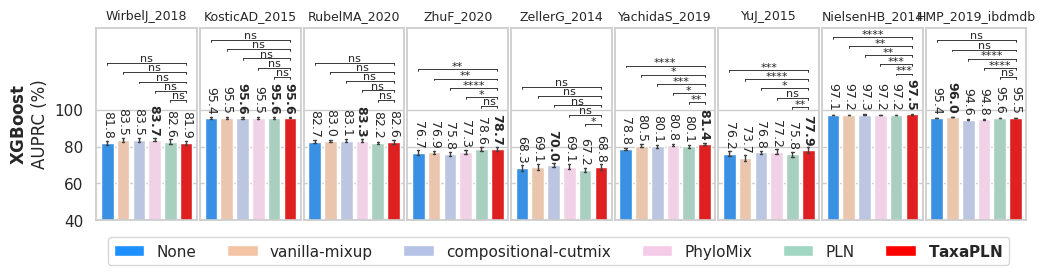

In [42]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats                         

target = 'VampPLN-Tree'
strategy_colors = {
    'None': '#1E90FF',
    'vanilla-mixup': '#F3C4A3',
    'compositional-cutmix': '#B6C3E7',
    'PhyloMix': '#F5CCE8',
    'VampPLN': '#A1D6C2',
    'VampPLN-Tree': 'tomato',
    target: 'red',
}

sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(1, len(data), figsize=(12, 2.5), sharey=True,
                        gridspec_kw={'wspace': 0.03})
if not isinstance(axs, np.ndarray):       
    axs = np.array([axs])

y_max = 100.
for i, scenario in enumerate(data):
    df_wide = (pd.DataFrame(metric_study[scenario])[list(strategy_colors.keys())] * 100)
    df_long = df_wide.melt(var_name='strategy', value_name='score')
    df_long['strategy'] = pd.Categorical(df_long['strategy'],
                                         categories=strategy_colors.keys(),
                                         ordered=True)

    palette = [strategy_colors[s] for s in df_long['strategy'].cat.categories]

    sns.barplot(data=df_long,
                x='strategy',
                y='score',
                order=strategy_colors.keys(),
                palette=palette,
                ax=axs[i],
                estimator=np.mean,
                errorbar=('ci', 95),
                capsize=0.15,
                errwidth=1.0,
                width=0.8)


    group_stats = df_wide.agg(['mean', 'sem']).T
    group_stats['ci95'] = 1.96 * group_stats['sem']
    for j, (mean_val, ci) in enumerate(zip(group_stats['mean'], group_stats['ci95'])):
        y_text = mean_val + 2.5          
        mean_str = f'{mean_val:.1f}'
        if np.round(mean_val,1) == np.round(group_stats['mean'].max(),1):
            mean_str = '$\\bf{'+mean_str+'}$'
        axs[i].text(j, y_text, mean_str,
                    ha='center', va='bottom', fontsize=9, rotation=-90)

    j_max = len(group_stats) - 1                          
    vals0 = df_wide[target]
    upper0 = vals0.mean() + 1.96 * stats.sem(vals0) + 5

    for j, col in enumerate(group_stats.index):
        if col == target:
            continue
        other_vals = df_wide[col]
        y = upper0 + 12 + (j_max - j) * 5

        # horizontal line
        axs[i].plot([j_max, j], [y, y], color='k', lw=0.6)
        # vertical ticks
        axs[i].plot([j_max, j_max], [y, y-1.], color='k', lw=0.6)
        axs[i].plot([j, j], [y, y-1.], color='k', lw=0.6)

        p_val = p_sig.loc[scenario, col]
        y_textpvalue = y - 0.2
        if '*' in f"{p_val}":
            y_textpvalue = y_textpvalue - 0.9
        axs[i].text((j_max + j)/2, y_textpvalue, f"{p_val}",
                    ha='center', va='bottom', fontsize=8)
        y_max = max(y_max, y + 5.)
    axs[i].set_title(scenario, fontsize=9)
    axs[i].set_ylim(55, y_max)            
    axs[i].set_xlabel('')
    axs[i].set_xticks([])

classifier_name = classifier_type
if classifier_type == 'RF':
    classifier_name = 'Random\;\;\;Forest'
elif classifier_type == 'logreg':
    classifier_name = 'Logistic\;\;\;Regression'
elif classifier_type == 'mlp':
    classifier_name = 'MLP'
elif classifier_type == 'svm':
    classifier_name = 'svm'
elif classifier_type == 'svm_rbf':
    classifier_name = 'SVM\;\;(RBF)'
axs[0].set_ylabel('$\\bf{'+classifier_name+'}$\nAUPRC (%)')
axs[0].set_yticks([tick for tick in axs[0].get_yticks() if tick <= 100])

legend_handles = []
for s, color in strategy_colors.items():
    s_name = s
    if s_name == 'VampPLN-Tree':
        s_name = 'TaxaPLN'
    if s_name == 'VampPLN':
        s_name = 'PLN'
    legend_handles += [Patch(facecolor=color, label=('$\\bf{'+s_name+'}$' if 'TaxaPLN' in s_name else s_name))]

fig.legend(handles=legend_handles, loc='lower center',
           ncol=len(strategy_colors), bbox_to_anchor=(0.51, -0.1),
           frameon=True)
plt.tight_layout()

savefig(classifier_type + f'-ratio{augment_ratio}-preproc{preprocessing.upper()}-barplot')

### Hold-out HMP augmentation

We perform a 100 Hold-Out experiment on the `HMP_2019_ibdmdb` dataset by varying the number of training elements in the cohorts. This way, we assess the capacity of the model to provide interesting performance gains when the dataset size is small, as well as the trend as it gets bigger.

In [43]:
from plntree import PLNTree
from plntree.data import cMD

levels = ('c', 's')
prevalence = 0.15
total_reads = 100_000

def get_disease_samples(disease, X, meta):
    """
    Fetch the training samples associated to a given disease
    """
    disease_index = meta[meta.study_condition == disease].index
    return X.loc[disease_index].copy()

def get_holdout_dataset(study, n_holdout, train_proportion, cov=False, save_folder='cache/', return_all=False, seed=0):
    """
    Hold-Out training set builder.
    """
    seed_all(seed)
    metadata = cMD.metadata(directory='./plntree/data/cMD')
    counts = cMD.get_study(
        study=study,
        prevalence=prevalence,
        total_reads=total_reads,
        taxonomic_levels=levels,
        directory='./plntree/data/cMD',
    )
    metadata = metadata.loc[counts.index]
    # Filter metadata
    covariates = preprocess_covariates(metadata)
    levels_str = ''
    for level in levels:
        levels_str += level
    prefix_all = f'plntreeHO-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'

    dic_data = {}
    for disease in data[study]:
        datasets = []
        for i in range(n_holdout):
            ho_file_name = save_folder + prefix_all + '-ho' + str(i) + '.csv'
            if not os.path.isfile(ho_file_name):
                raise ValueError(f'[INFO] Hold-out not found:{ho_file_name}')
            df_ho = pd.read_csv(ho_file_name)
            df_ho['patient_id'] = df_ho['patient_id'].astype(str)
            df_ho['train_label'] = df_ho['train_label'].astype(int)
            # We keep the cross-validation pipeline to be able to use the same functions as in the CV code
            # But since it's just a hold-out, we will use only "one fold", that's actually a simple split
            folds = []
            for k in range(1):
                train_fold = df_ho[df_ho['train_label'] == 1]
                test_fold = df_ho[df_ho['train_label'] == 0]
                train_indices = list(train_fold['patient_id'].values.flatten())
                test_indices = list(test_fold['patient_id'].values.flatten())
                X_train = counts.loc[train_indices].copy()
                X_test = counts.loc[test_indices].copy()
                X_train = get_disease_samples(disease, X_train, metadata.loc[X_train.index])
                X_test = get_disease_samples(disease, X_test, metadata.loc[X_test.index])
                cov_train = covariates.loc[X_train.index].copy()
                cov_test = covariates.loc[X_test.index].copy()
                if not cov:
                    cov_train = None
                    cov_test = None
                folds.append((X_train, cov_train, X_test, cov_test))
            datasets.append(folds)
        dic_data[disease] = datasets
    if return_all:
        return dic_data, counts, metadata
    else:
        return dic_data

def get_plntree_holdout(study, n_holdout, train_proportion, cov=False, save_folder='cache/'):
    """
    Fetching PLN-Tree models associated to the hold-out training of the given study
    """
    prevalence = 0.15
    levels_str = ''
    for level in levels:
        levels_str += level
    prefix_all = f'plntreeHO-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'

    # Parameters for the PLN-Tree model
    cov_params = {'type':'film', 'n_heads': 0, 'n_layers': 2}
    n_latent_layers, (emb_name, variational_approx) = (1, embedder_params(
        embedder_type='GRU',
        embedding_size=32,
        n_embedding_layers=2,
        n_embedding_neurons=32,
        n_after_layers=2
        )
    )

    dic_data, counts, meta = get_holdout_dataset(study, n_holdout, train_proportion=train_proportion, cov=cov, save_folder=save_folder, return_all=True)
    models = {}
    for disease in dic_data.keys():
        datasets = dic_data[disease]
        prefix = prefix_all + '-' + disease
        models[disease] = {}
        for cv, folds in enumerate(datasets):
            models[disease][cv] = []
            for k, (X_train, cov_train, X_test, cov_test) in enumerate(folds):
                if not cov:
                    load_file = prefix + '_' + str(n_latent_layers) + '--' + emb_name + f'_cv{cv}-{k}'
                else:
                    load_file = prefix + '_' + str(n_latent_layers) + '--all' + '-' + cov_params['type'] + str(cov_params['n_heads']) + '.' + str(cov_params['n_layers']) + '--' + emb_name + f'_cv{cv}-{k}'
                X_train_disease = get_disease_samples(disease, X_train, meta.loc[X_train.index])
                cov_train_disease = cov_train.loc[X_train_disease.index] if cov else None

                estimator, losses, monitor = load_plntree(
                    X_train_disease, cov_train_disease, cov_params, n_latent_layers, variational_approx, 
                    load_file=load_file, save_folder=save_folder
                )
                models[disease][cv].append((estimator, losses, X_train, X_test))
    return models

In [44]:
from baseline_augmentation import vanilla_mixup, compositional_cutmix, phylomix
import pickle

train_proportion = 0.8
prevalence = 0.15

def get_train_test_dataset_holdout(study, n_holdout, train_proportion, cov, augment_strategy='None', augment_ratio=2., seed=0):
    """
    Train/Test sets builder with integrated augmentation
    """
    if 'PLN-Tree' in augment_strategy or 'TaxaPLN' in augment_strategy:
        plntree_models = get_plntree_holdout(study, n_holdout=n_holdout, train_proportion=train_proportion)
        
    dic_data = get_holdout_dataset(study, n_holdout=n_holdout, train_proportion=train_proportion, cov=cov)
    train_test_datasets = [[None] for j in range(n_holdout)]
    for label, disease in enumerate(dic_data):
        for cv, datasets in enumerate(dic_data[disease]):
            for fold, (X_train, cov_train, X_test, cov_test) in enumerate(datasets):
                for ind in X_test.index:
                    if ind in X_train.index:
                        raise ValueError('Data leak in train/test sets.')
                        
                if 'PLN-Tree' in augment_strategy or 'TaxaPLN' in augment_strategy:
                    plntree = plntree_models[disease][cv][fold][0]
                    X_train = X_train[plntree.counts.columns]
                    X_test = X_test[plntree.counts.columns]
                    assert(X_train.columns == plntree.counts.columns).all()
                    assert(X_test.columns == plntree.counts.columns).all()
                
                X_aug = None
                n_aug = int(X_train.shape[0]*(augment_ratio-1))
                if n_aug > 0:
                    if augment_strategy == 'PLN-Tree' or augment_strategy == 'PLN-Tree (cov)':
                        plntree = plntree_models[disease][cv][fold][0]
                        X_aug = plntree.sample(n_aug, seed=seed)[0][:, -1].numpy()
                    elif augment_strategy == 'VampPLN-Tree' or augment_strategy == 'VampPLN-Tree (cov)':
                        if cov:
                            seed_all(seed)
                            plntree = plntree_models[disease][cv][fold][0]
                            cov_ = plntree.covariates
                            indices = np.random.choice(np.arange(0, cov_.shape[0]), size=n_aug, replace=True)
                            cov_sampled = cov_[indices]
                            X_aug = plntree.vamp_sample(
                                covariates=cov_sampled, 
                                seed=seed,
                            )[0][:, -1].numpy()
                        else:
                            X_aug = plntree.vamp_sample(
                                n_samples=n_aug,
                                seed=seed, 
                                mean=False, 
                            )[0][:, -1].numpy()
                    elif augment_strategy == 'PLN' or augment_strategy == 'VampPLN':
                        levels_str = ''
                        for level in levels:
                            levels_str += level
                        prefix_all = save_folder + f'plntreeCV-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'
                        pln_file = prefix_all + f'-PLN0.0.6-{disease}-cv{cv}-{fold}'
                        if os.path.isfile(pln_file):
                            pln = pickle.load(open(pln_file, 'rb'))
                        else:
                            pln = Pln(endog=X_train)
                            pln.fit(verbose=False)
                            pickle.dump(pln, open(pln_file, 'wb'))
                        if augment_strategy == 'PLN':
                            X_aug = sample(pln, n_aug, covariates=None, seed=seed)[0][:, :]
                        else:
                            X_aug = vamp_sample(pln, n_aug)[0][:, :]
                        assert(pln.endog.numpy().shape[0] == X_train.shape[0])
                        X_train = pd.DataFrame(pln.endog.numpy())
                        assert(X_aug.shape[0] == n_aug)
                    elif augment_strategy == 'PLN (cov)' or augment_strategy == 'VampPLN (cov)':
                        levels_str = ''
                        for level in levels:
                            levels_str += level
                        prefix_all = save_folder + f'plntreeCV-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'
                        pln_file = prefix_all + f'-PLNcov-{disease}-cv{cv}-{fold}'
                        if os.path.isfile(pln_file):
                            pln = pickle.load(open(pln_file, 'rb'))
                        else:
                            pln = Pln(endog=X_train, exog=cov_train)
                            pln.fit(verbose=False)
                            pickle.dump(pln, open(pln_file, 'wb'))
                        if augment_strategy == 'PLN':
                            X_aug = sample(pln, n_aug, covariates=None, seed=seed)[0][:, :]
                        else:
                            X_aug = vamp_sample(pln, n_aug)[0][:, :]
                    elif augment_strategy == 'vanilla-mixup':
                        X_aug = vanilla_mixup(X_train.to_numpy(), n_aug)
                    elif augment_strategy == 'compositional-cutmix':
                        X_aug = compositional_cutmix(X_train.to_numpy(), n_aug, normalize=False)
                    elif 'PhyloMix' in augment_strategy:
                        X_aug = phylomix(X_train, n_aug, tree='taxonomy', clr='CLR' in augment_strategy).to_numpy()
                    elif augment_strategy == 'None':
                        X_aug = None
                    else:
                        raise ValueError(f'Strategy {augment_strategy} was not found.')
                
                
                if X_aug is not None:
                    assert not np.isnan(X_aug).any(), "Generated data contains a NaN."
                    assert X_aug.shape[0] == n_aug, "Generated data does not match the amount of augmentation asked for."
                    X_train_disease = np.concatenate((X_train.to_numpy(), X_aug))
                else:
                    X_train_disease = X_train.to_numpy()
    
                y_train_disease = np.ones(X_train_disease.shape[0]) * label
                y_test_disease = np.ones(X_test.shape[0]) * label
                        
                if train_test_datasets[cv][fold] == None:
                    train_test_datasets[cv][fold] = [X_train_disease, y_train_disease, X_test.to_numpy(), y_test_disease]
                else:
                    train_test_datasets[cv][fold] = [
                        np.concatenate((train_test_datasets[cv][fold][0], X_train_disease)),
                        np.concatenate((train_test_datasets[cv][fold][1], y_train_disease)),
                        np.concatenate((train_test_datasets[cv][fold][2], X_test.to_numpy())),
                        np.concatenate((train_test_datasets[cv][fold][3], y_test_disease))
                    ]
    return train_test_datasets

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC

def get_classifier(classifier_type):
    """
    Classifier object and params getter.
    """
    if classifier_type == 'logreg':
        classifier = LogisticRegression
        classifier_params = {}
    elif classifier_type == 'RF':
        classifier = RandomForestClassifier
        classifier_params = {}
    elif classifier_type == 'XGBoost':
        classifier = GradientBoostingClassifier
        classifier_params = {'learning_rate': 0.05}
    elif classifier_type == 'svm':
        classifier = LinearSVC
        classifier_params = {}
    elif classifier_type == 'svm_rbf':
        classifier = SVC
        classifier_params = {}
    elif classifier_type == 'mlp':
        classifier = MLPClassifier
        classifier_params = {'hidden_layer_sizes':(256, 128), 'solver':'adam', 'max_iter':200}
    elif classifier_type == 'mlp_tuned':
        classifier = MLPClassifier
        classifier_params = {'hidden_layer_sizes':(256, 128, 128, 64), 'solver':'adam', 'max_iter':200, 'alpha':1e-3}
    elif classifier_type == 'bigmlp':
        classifier = MLPClassifier
        classifier_params = {'hidden_layer_sizes':(512, 256, 128), 'solver':'adam', 'max_iter':200, 'alpha': 1e-2}
    return classifier, classifier_params

def clr(X):
    """
    CLR transform preprocessing
    """
    if (X < 0).any():
        print(X[X < 0])
        assert not (X < 0).any(), "Data contains negative entries and can not be CLR transformed."
    log_X = np.log(X + .5)
    assert not np.isnan(log_X).any(), "Log on data contains a NaN."
    clr_X = log_X - np.mean(log_X, axis=1, keepdims=True)
    return clr_X

def proportion(X):
    """
    Relative abundance preprocessing
    """
    return X / (X.sum(-1, keepdims=True) + 1e-32)

def augmented_classifiers_holdout(disease, classifier_type, train_test_datasets, preprocessing=lambda x: x, seed=0):
    """
    Performing data augmentation with the given classifier; handles train/test sets for later evaluation.
    """
    classifier, params = get_classifier(classifier_type)
    wrapper = [[] for i in range(len(train_test_datasets))]
    levels_str = ''
    for level in levels:
        levels_str += level
    prefix_all = save_folder + f'plntreeHO-LV{levels_str}-prev{prevalence}-s{seed}'
    for cv in range(len(train_test_datasets)):
        for fold, (X_train, y_train, X_test, y_test) in enumerate(train_test_datasets[cv]):
            seed_all(seed)
            fold_file = prefix_all + f'-predictions-{disease}-cv{cv}-{fold}.csv'
            try:
                results = pd.read_csv(fold_file)
                assert (y_test == results['test'].to_numpy()).all()
                y_pred = results['prediction']
            except:
                print('     - Learning classifier: ' + fold_file)
                assert classifier_type in fold_file, f'[Error] About to train {classifier_type} onto {disease}.'
                assert len(np.unique(y_train)) == 2
                assert len(np.unique(y_test)) == 2
                indices_train = np.arange(0, y_train.shape[0], 1)
                np.random.shuffle(indices_train)
                X_train_prec = preprocessing(X_train)
                X_test_prec = preprocessing(X_test)
                assert not np.isnan(X_train_prec).any(), "Preprocessed training data contains a NaN."
                assert not np.isnan(X_test_prec).any(), "Preprocessed test data contains a NaN."
                model = classifier(**params).fit(X_train_prec[indices_train], y_train[indices_train])
                try:
                    y_pred = model.predict_proba(X_test_prec)[:, 1]
                except:
                    y_pred = model.decision_function(X_test_prec)
                results = pd.DataFrame()
                results['test'] = y_test
                results['prediction'] = y_pred
                results.to_csv(fold_file, index=False)
            wrapper[cv].append((results['prediction'], results['test']))
    return wrapper

def evaluate_classifiers(wrapper, metric=average_precision_score):
    """
    Evaluate the augmented_classifier output with the given metric
    """
    metrics = []
    for cv in range(len(wrapper)):
        metrics_fold = 0.
        for fold, (y_pred, y_test) in enumerate(wrapper[cv]):
            metrics_fold += metric(y_test, y_pred) / len(wrapper[cv])
        metrics.append(metrics_fold)
    return np.array(metrics)

In [46]:
import os

study = 'HMP_2019_ibdmdb'
augment_ratio = 2.
preprocessing = clr
n_holdout = 100

classifier_types = ['RF', 'XGBoost', 'mlp', 'logreg']
strategies = [
    'None',
    'PhyloMix',
    'VampPLN-Tree',
]
train_proportions = [0.05, 0.1, 0.2, 0.3]


levels_str = ''
for level in levels:
    levels_str += level
prefix_file = save_folder + f'plntreeHO-LV{levels_str}-prev{prevalence}-s{seed}'
perfs_study = {
    strategy:{
        classifier_type:{
            train_proportion:{} for train_proportion in train_proportions
        } for classifier_type in classifier_types
    } for strategy in strategies
}
print(study, ':')
for strategy in strategies:
    for classifier_type in classifier_types:
        for train_proportion in train_proportions:
            seed_all(seed)
            filetag = f'{study}_{strategy}_{classifier_type}_{augment_ratio}_{int(100*train_proportion)}perc'
            fold_file = prefix_file + f'-predictions-{filetag}-cv{n_holdout-1}-0.csv'
            train_test_datasets = get_train_test_dataset_holdout(
                        study, n_holdout=n_holdout, train_proportion=train_proportion, 
                        cov='(cov)' in strategy, 
                        augment_strategy='None' if os.path.isfile(fold_file) else strategy, 
                        augment_ratio=augment_ratio, 
                        seed=seed
                )
            wrapper = augmented_classifiers_holdout(
                filetag, 
                classifier_type=classifier_type,
                train_test_datasets=train_test_datasets, 
                preprocessing=preprocessing, 
                seed=seed,
            )
            scores = evaluate_classifiers(wrapper, metric=average_precision_score)
            perfs_study[strategy][classifier_type][train_proportion] = wrapper #scores
            print('   *', strategy, f'{int(np.round(train_proportion*100))}% {classifier_type}: AUPRC', np.round(scores.mean()*100, 1), f'({np.round(scores.std()*100, 1)})')

HMP_2019_ibdmdb :
   * None 5% RF: AUPRC 60.5 (5.1)
   * None 10% RF: AUPRC 71.1 (4.8)
   * None 20% RF: AUPRC 81.6 (4.0)
   * None 30% RF: AUPRC 87.5 (2.9)
   * None 5% XGBoost: AUPRC 50.0 (7.6)
   * None 10% XGBoost: AUPRC 67.3 (5.4)
   * None 20% XGBoost: AUPRC 81.4 (4.1)
   * None 30% XGBoost: AUPRC 88.0 (2.7)
   * None 5% mlp: AUPRC 73.5 (4.3)
   * None 10% mlp: AUPRC 86.3 (3.3)
   * None 20% mlp: AUPRC 95.2 (1.7)
   * None 30% mlp: AUPRC 97.8 (1.1)
   * None 5% logreg: AUPRC 63.3 (5.8)
   * None 10% logreg: AUPRC 71.3 (5.2)
   * None 20% logreg: AUPRC 77.0 (3.8)
   * None 30% logreg: AUPRC 78.9 (2.4)
   * PhyloMix 5% RF: AUPRC 62.2 (4.8)
   * PhyloMix 10% RF: AUPRC 72.6 (4.9)
   * PhyloMix 20% RF: AUPRC 82.8 (3.6)
   * PhyloMix 30% RF: AUPRC 88.1 (2.8)
   * PhyloMix 5% XGBoost: AUPRC 55.4 (6.3)
   * PhyloMix 10% XGBoost: AUPRC 69.6 (4.3)
   * PhyloMix 20% XGBoost: AUPRC 82.4 (4.2)
   * PhyloMix 30% XGBoost: AUPRC 88.0 (2.5)
   * PhyloMix 5% mlp: AUPRC 72.1 (4.6)
   * PhyloMix 10%

In [47]:
# Performing metric evaluation on each wrapper after augmentation and classifier training
metric_study = {
    classifier_type: {
        strategy: {
            train_proportion: evaluate_classifiers(perfs_study[strategy][classifier_type][train_proportion], metric=average_precision_score) for train_proportion in train_proportions
        } for strategy in strategies
    } for classifier_type in classifier_types
}

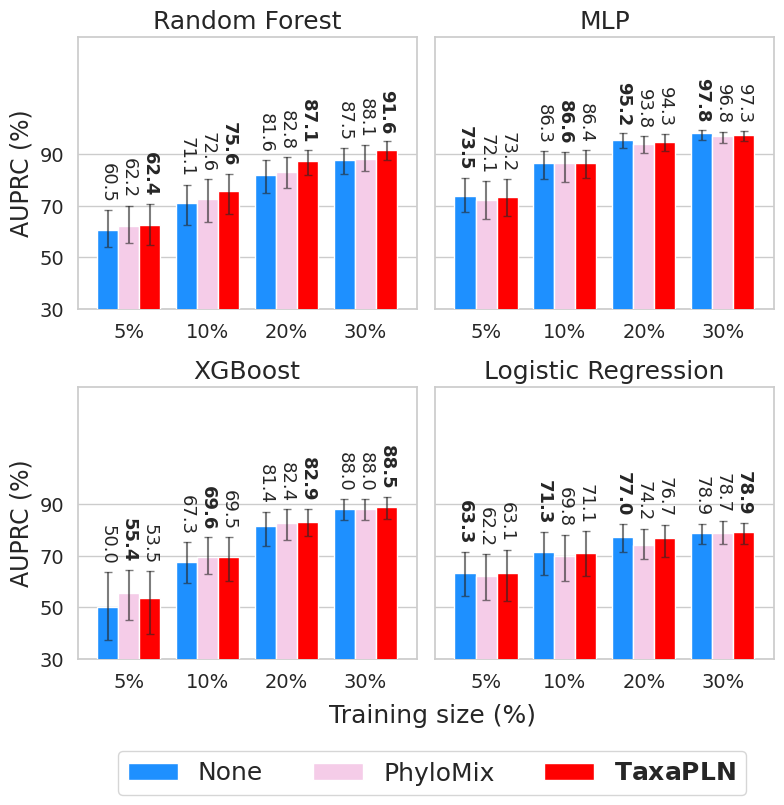

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer

# Plotting the performances with varying training size with PhyloMix and TaxaPLN

sns.set_theme(style="whitegrid")

strategy_colors = {
    'None': '#1E90FF',
    'PhyloMix': '#F5CCE8',
    'VampPLN-Tree': 'red',
}

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, classifier_type in enumerate(classifier_types):
    df_raw  = pd.DataFrame(metric_study[classifier_type])
    df_mean = df_raw.applymap(np.mean)
    df_low  = df_raw.applymap(lambda x: np.quantile(x, 0.05))
    df_high = df_raw.applymap(lambda x: np.quantile(x, 0.95))

    lower = (df_mean - df_low).T.to_numpy()        
    upper = (df_high - df_mean).T.to_numpy()
    yerr  = np.stack([lower, upper], axis=1)        

    ax = axs[i%2][1 if i >= 2 else 0]
    bars = df_mean.plot(kind='bar',
                        yerr=yerr,
                        width=0.8,
                        capsize=3,
                        error_kw={'alpha': 0.6},
                        color=strategy_colors,
                        ax=ax,
                        zorder=3,
                        legend=False)

    bar_containers = [c for c in ax.containers if isinstance(c, BarContainer)]
    
    best_col_by_row = df_mean.values.argmax(axis=1)   
    for col_idx, container in enumerate(bar_containers):         
        for row_idx, bar in enumerate(container):            
            mean_val = bar.get_height()
            err_up   = upper[col_idx, row_idx]
            y_pos    = mean_val + err_up + 0.01
    
            ax.annotate(f'{mean_val*100:.1f}',
                        xy=(bar.get_x() + bar.get_width()/2, y_pos + 0.02),
                        ha='center', va='bottom', fontsize=13,
                        fontweight='bold' if col_idx == best_col_by_row[row_idx] else 'normal',
                        rotation=-90)


    ax.set_ylim(0.3, 1.35)
    ax.set_yticks([0.3, 0.5, 0.7, 0.9])
    ax.set_yticklabels((np.array([0.3, 0.5, 0.7, 0.9])*100).astype(int), size=14)
    ax.set_xticklabels([f'{int(x*100)}%' for x in train_proportions], rotation=0, size=14)

    if i == 0:
        ax.set_ylabel("AUPRC (%)", size=17)
    else:
        ax.set_yticklabels(['', '', '', ''])

    title_map = {'RF': 'Random Forest',
                 'mlp': 'MLP',
                 'XGBoost': 'XGBoost',
                 'logreg': 'Logistic Regression'}
    ax.set_title(title_map[classifier_type], size=18)
    ax.grid(False)
    ax.grid(True, axis='y')

axs[1][0].set_ylabel("AUPRC (%)", size=17)
axs[1][0].set_yticklabels(axs[0][0].get_yticklabels())
handles, labels = axs[0][0].get_legend_handles_labels()
labels = ['None', 'PhyloMix', '$\\bf{TaxaPLN}$']
fig.legend(handles, labels,
           loc='lower center',
           ncol=len(labels),
           bbox_to_anchor=(0.55, -0.02),
           fontsize=18,
           frameon=True)
fig.supxlabel("Training size (%)", x=0.55, y=0.08, size=18)   

plt.tight_layout(rect=[0, 0.05, 1, 1])
savefig('HMP_progressive_training_size_augmentation')


# Covariate-aware TaxaPLN augmentation

In this section, we demonstrate the capacities of our generative approach to perform covariate-aware data augmentation. The method relies on a FiLM architecture to incorporate covariate within PLN-Tree. See the original paper for more details.

## Disclaimers
- `KosticAD_2015` does not have the basic covariates we need to incorporate it in our study. Besides, `NielsenHB_2014` has duplicated metadata issues, so we prefer to leave it out.
- The `pyPLNmodels` package which implements the PLN models is very sensitive to covariates invertibility. This code will only run if you edit the package at `_closed_forms.py:66` to use `torch.linalg.pinv` instead of `torch.inverse`, thus performing pseudo-inversion during training.

In [32]:
# Defining the datasets for covariate-aware augmentation
data = {
    'WirbelJ_2018': ['CRC', 'control'],
    'HMP_2019_ibdmdb': ['IBD', 'control'],
    'ZhuF_2020': ['schizophrenia', 'control'],
    'RubelMA_2020': ['STH', 'control'],
    'ZellerG_2014': ['adenoma', 'control'],
    'YachidaS_2019': ['adenoma', 'control'], 
    'YuJ_2015': ['CRC', 'control'],
    #'NielsenHB_2014': ['IBD', 'control'], # Issues with duplicated covariates
}

## Sanity check about PLN-Tree with covariates training

We check that no pathological behavior is observed during training with the FiLM architecture.

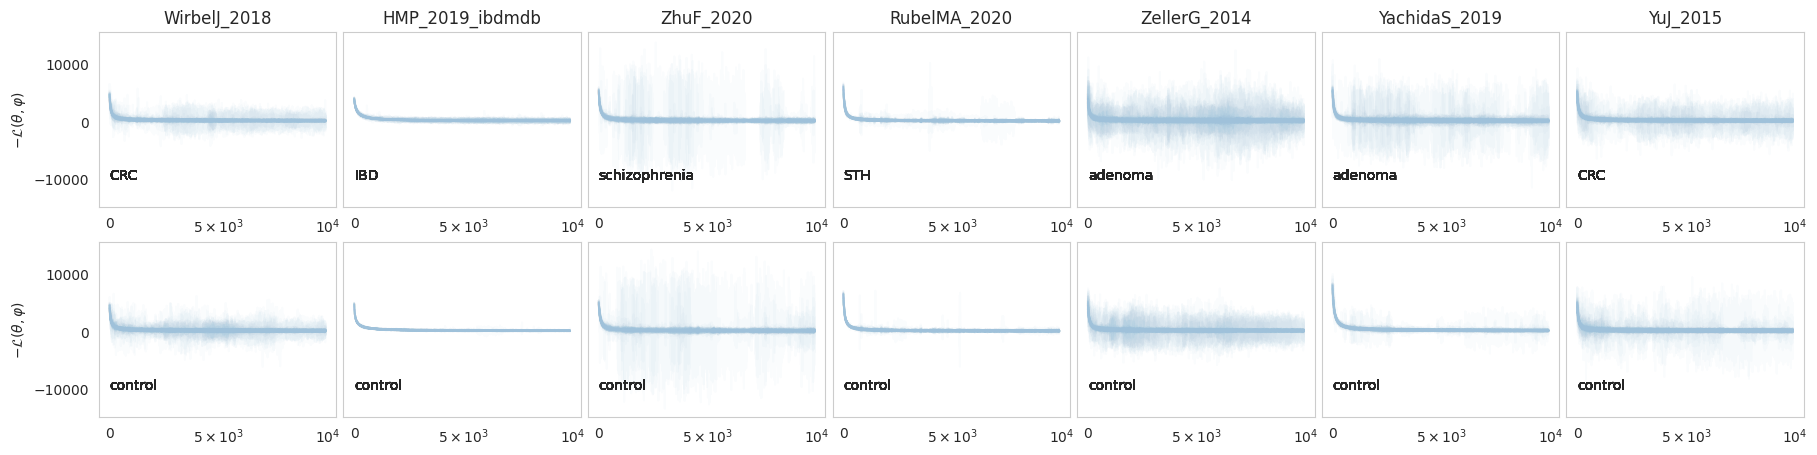

In [33]:
n_cv = 5

fig, axs = plt.subplots(2, len(data), figsize=(22,5), sharey=True, gridspec_kw={'wspace': 0.03})

for i, study in enumerate(data):
    plntree_models = get_plntree(study, n_cv, cov=True)
    for j, disease in enumerate(data[study]):
        for cv in range(n_cv):
            for (plntree, losses, X_train, X_test) in plntree_models[disease][cv]:
                axs[j][i].plot(losses[100:], color='C0', alpha=0.02)
                #axs[j][i].set_yscale('symlog')
                axs[j][i].text(0., -10e3, disease)
        if i != 0:
            axs[j][i].get_yaxis().set_visible(False)
        axs[j][i].set_xticks([0, 5000, 10000])
        axs[j][i].set_xticklabels(['0', '$5 \\times 10^3$', '$10^4$'])
        axs[j][i].grid(False)
    axs[0][i].set_title(study)
    axs[0][0].set_ylabel('$-\\mathcal{L}(\\theta, \\varphi)$')
    axs[1][0].set_ylabel('$-\\mathcal{L}(\\theta, \\varphi)$')

## Conditional alpha diversity benchmark

We verify the $\alpha$-diversity preservation with generated data.

In [34]:
from baseline_augmentation import vanilla_mixup, compositional_cutmix, phylomix
import pickle

cv = 1
n_samples = 500

X = {}
for i, study in enumerate(data):
    print('[*]', study)
    plntree_models = get_plntree(study, cv, cov=True)
    X_disease = {}
    for j, disease in enumerate(data[study]):
        print('    |-', disease)
        # Initialize dictionary of augmented data
        X_aug = None
        for (plntree, losses, X_train, X_test) in plntree_models[disease][cv-1]:
            seed_all(seed)
            # Generated synthetic microbiome samples with every methods, and store for analysis
            X_plntree = plntree.vamp_sample(n_samples, seed=seed)[0]
            # Ablation study: learning PLN (no taxonomic information)
            pln = Pln(endog=plntree.counts, exog=plntree.covariates)
            pln.fit()
            X_pln = torch.zeros_like(X_plntree)
            seed_all(seed)
            X_pln[:, -1] = vamp_sample(pln, n_samples)[0]
            X_aug_fold = {
                    disease: plntree.hierarchical_counts,
                    'TaxaPLN': X_plntree,
                    'PLN': X_pln,
                }
            
            if X_aug is None:
                X_aug = X_aug_fold
            else:
                for key in X_aug:
                    X_aug[key] = torch.cat((X_aug[key], X_aug_fold[key]))
        X_disease[disease] = X_aug
    X[study] = X_disease

[*] WirbelJ_2018
    |- CRC
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 454 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 491 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 495 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 477 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 489 iterations
    |- control
Setting the offsets as the log of the

In [62]:
colors = {
    'Original': '#1E90FF',
    'TaxaPLN': 'red',           
    'PLN': '#A1D6C2',                
}

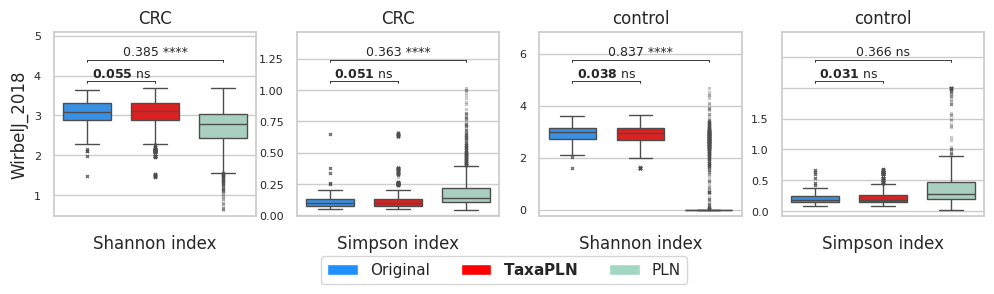

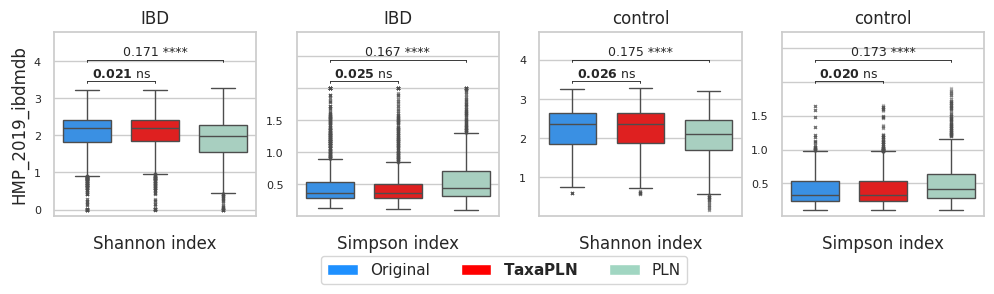

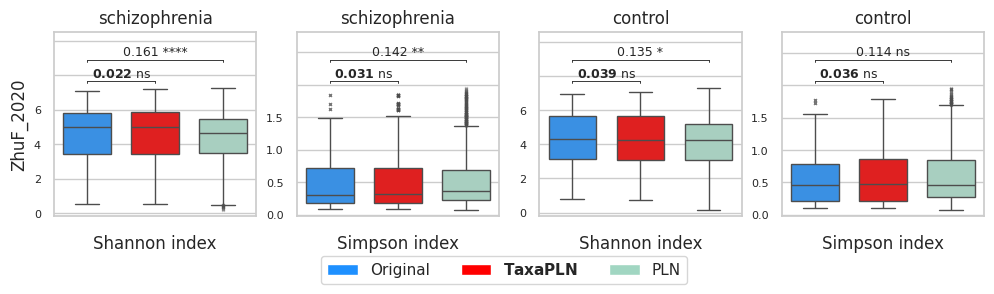

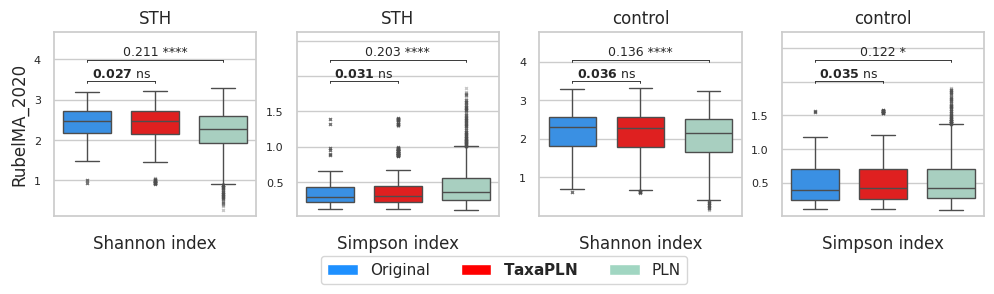

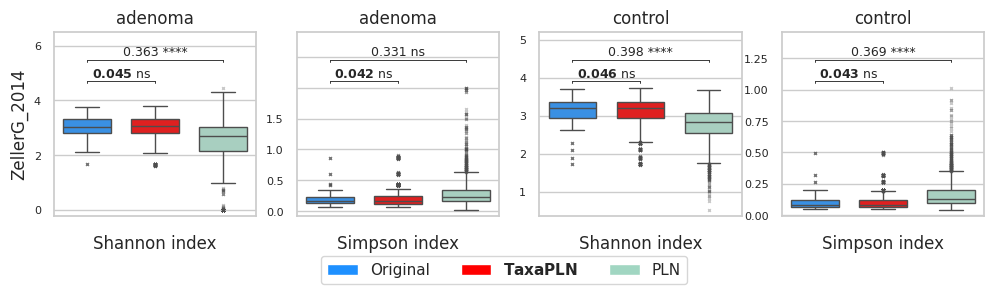

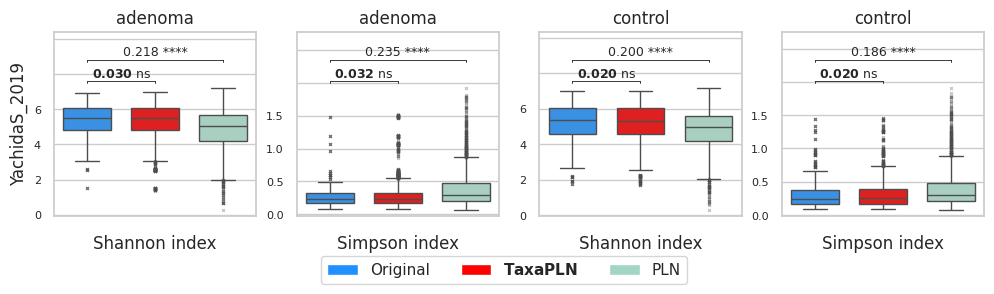

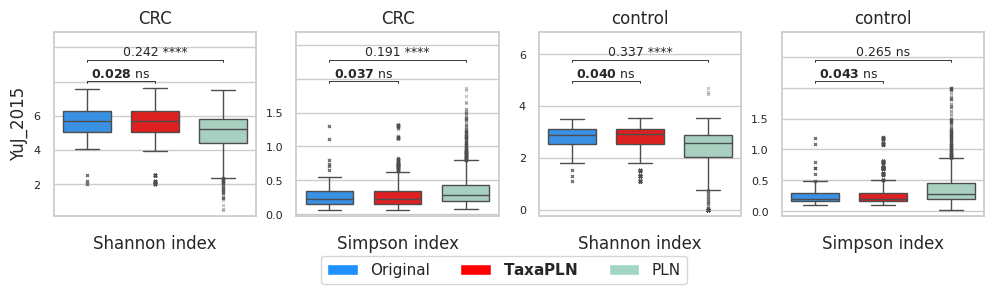

In [63]:
from scipy.stats import ks_2samp, mannwhitneyu
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

alpha_metrics = {
    'Shannon index': shannon_index,
    'Simpson index': simpson_index,
}

pvalues = {
    'Shannon index': {group:[] for group in colors},
    'Simpson index': {group:[] for group in colors},
}

def pvalue_map(pvalue):
    if pvalue <= 0.0001:
        return '****'
    elif pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return 'ns'


for i, study in enumerate(X):
    fig, axs = plt.subplots(1, len(alpha_metrics)*2, figsize=(12, 2.3))
    for j, disease in enumerate(X[study]):
        alpha_div = pd.DataFrame()
        for strategy in X[study][disease]:
            label = strategy if strategy != disease else 'Original'
            X_L = X[study][disease][strategy][:, -1]
            df = pd.DataFrame()
            for metric, metric_fun in alpha_metrics.items():
                df[metric] = metric_fun(X_L)
            df['Group'] = label
            alpha_div = pd.concat((alpha_div, df), ignore_index=True)
            
        order_groups = ['Original'] + [g for g in alpha_div['Group'].unique() if g != 'Original']

        for k, metric in enumerate(alpha_metrics):
            seed_all(seed)
            ax = axs[j*len(alpha_metrics) + k]

            sns.boxplot(
                data=alpha_div,
                x="Group", y=metric,
                width=0.7, order=order_groups,
                ax=ax, palette=colors,
                showfliers=True,
                flierprops=dict(marker='x', markersize=2, alpha=0.3)
            )

            x_orig   = 0
            vals_orig = alpha_div.loc[alpha_div['Group'] == 'Original', metric]
            
            y0, y1   = ax.get_ylim()
            data_max = alpha_div[metric].max()
            y_range  = y1 - y0
            
            base_offset   = 0.05 * y_range           
            step_offset   = 0.16 * y_range           # vertical gap between stacked brackets
            tick_height   = 0.015 * y_range          # length of the little vertical ticks
            text_offset   = 0.01 * y_range           # distance between bracket and KS text
            
            n_brackets = len(order_groups) - 1
            top_needed = data_max + base_offset + n_brackets * step_offset
            if top_needed > y1:
                ax.set_ylim(y0, top_needed + 0.05 * y_range)  
            
            ks_vals = []
            for idx, grp in enumerate(order_groups[1:], start=1):             # skip Original
                vals_grp = alpha_div.loc[alpha_div['Group'] == grp, metric]
                ks_stat  = ks_2samp(vals_orig, vals_grp, nan_policy='omit').statistic
                ks_vals.append(ks_stat)
            
            # find the smallest KS so we can bold it later
            ks_min = min(ks_vals)
            
            for idx, (grp, ks_stat) in enumerate(zip(order_groups[1:], ks_vals), start=1):
                vals_grp = alpha_div.loc[alpha_div['Group'] == grp, metric]
                pvalue = mannwhitneyu(vals_orig, vals_grp, alternative='two-sided', method='auto').pvalue
                pvalues[metric][grp] += [pvalue]
                y_bracket = data_max + base_offset + (idx-1)*step_offset
            
                # horizontal line
                ax.plot([x_orig, idx], [y_bracket, y_bracket], color='k', lw=0.6)
                # vertical ticks
                ax.plot([x_orig, x_orig], [y_bracket, y_bracket - tick_height], color='k', lw=0.6)
                ax.plot([idx, idx],     [y_bracket, y_bracket - tick_height], color='k', lw=0.6)
            
                stat_str = f"{ks_stat:.3f}"
                if ks_stat == ks_min:
                    stat_str = rf"$\bf{{{stat_str}}}$ " + pvalue_map(pvalue)
                else:
                    stat_str = stat_str + ' ' + pvalue_map(pvalue)
            
                ax.text((x_orig + idx)/2,
                        y_bracket + text_offset,
                        stat_str,
                        ha='center', va='bottom', fontsize=9)
            
            ax.set_title(f'{disease}')
            ax.set_ylabel('')
            ax.set_yticklabels(ax.get_yticklabels(), size=8)

    axs[0].set_ylabel(study)

    for j, ax in enumerate(axs):
        ax.set_xticklabels([], rotation=-90)
        ax.set_xlabel(list(alpha_metrics.keys())[j % len(alpha_metrics)])
    
    # legend
    handles = [Patch(facecolor=c, label=n if n != 'TaxaPLN' else '$\\bf{TaxaPLN}$') for n, c in colors.items()]
    fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.25), fontsize=11,
               ncol=len(handles), frameon=True)
    
    fig.subplots_adjust(bottom=0.08)
    file_name = f'conditional_alpha_diversity_benchmark_{study}'
    for metric in alpha_metrics.keys():
        file_name = file_name + '_' + metric
    savefig(file_name)

## Conditional data augmentation

We now perform conditional data augmentation, using similar functions as for the vanilla augmentation.

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC

def get_classifier(classifier_type):
    """
    Classifiers parameters and objects
    """
    if classifier_type == 'logreg':
        classifier = LogisticRegression
        classifier_params = {}
    elif classifier_type == 'RF':
        classifier = RandomForestClassifier
        classifier_params = {}
    elif classifier_type == 'XGBoost':
        classifier = GradientBoostingClassifier
        classifier_params = {
            'learning_rate': 0.05
        }
    elif classifier_type == 'svm':
        classifier = LinearSVC
        classifier_params = {}
    elif classifier_type == 'svm_rbf':
        classifier = SVC
        classifier_params = {}
    elif classifier_type == 'mlp':
        classifier = MLPClassifier
        classifier_params = {'hidden_layer_sizes':(256, 128), 'solver':'adam', 'max_iter':200}
    elif classifier_type == 'bigmlp':
        classifier = MLPClassifier
        classifier_params = {'hidden_layer_sizes':(512, 256, 128), 'solver':'adam', 'max_iter':200, 'alpha': 1e-2}
    return classifier, classifier_params
    
def clr(X):
    """
    CLR transform preprocessing
    """
    if (X < 0).any():
        print(X[X < 0])
        assert not (X < 0).any(), "Data contains negative entries and can not be CLR transformed."
    log_X = np.log(X + .5)
    assert not np.isnan(log_X).any(), "Log on data contains a NaN."
    clr_X = log_X - np.mean(log_X, axis=1, keepdims=True)
    return clr_X

def proportion(X):
    """
    Relative abundance preprocessing
    """
    return X / (X.sum(-1, keepdims=True) + 1e-32)

def augmented_classifiers(disease, classifier_type, train_test_datasets, preprocessing=lambda x: x, seed=0):
    """
    Wrapper training using the given train/test sets, preprocessing and classifiers
    """
    classifier, params = get_classifier(classifier_type)
    wrapper = [[] for i in range(len(train_test_datasets))]
    levels_str = ''
    for level in levels:
        levels_str += level
    prefix_all = save_folder + f'conditional-plntreeCV-LV{levels_str}-prev{prevalence}-s{seed}'
    for cv in range(len(train_test_datasets)):
        for fold, (X_train, y_train, X_test, y_test) in enumerate(train_test_datasets[cv]):
            seed_all(seed)
            fold_file = prefix_all + f'-predictions-{disease}-cv{cv}-{fold}.csv'
            try:
                results = pd.read_csv(fold_file)
                assert (y_test == results['test'].to_numpy()).all()
                y_pred = results['prediction']
            except:
                print('     - Learning classifier: ' + fold_file)
                assert classifier_type in fold_file, f'[Error] About to train {classifier_type} onto {disease}.'
                assert len(np.unique(y_train)) == 2
                assert len(np.unique(y_test)) == 2
                indices_train = np.arange(0, y_train.shape[0], 1)
                np.random.shuffle(indices_train)
                X_train_prec = preprocessing(X_train)
                X_test_prec = preprocessing(X_test)
                assert not np.isnan(X_train_prec).any(), "Preprocessed training data contains a NaN."
                assert not np.isnan(X_test_prec).any(), "Preprocessed test data contains a NaN."
                model = classifier(**params).fit(X_train_prec[indices_train], y_train[indices_train])
                try:
                    y_pred = model.predict_proba(X_test_prec)[:, 1]
                except:
                    y_pred = model.decision_function(X_test_prec)
                results = pd.DataFrame()
                results['test'] = y_test
                results['prediction'] = y_pred
                results.to_csv(fold_file, index=False)
            wrapper[cv].append((results['prediction'], results['test']))
    return wrapper

def evaluate_classifiers(wrapper, metric=average_precision_score):
    """
    Evaluate a wrapper output from augmented_classifiers using the given metric
    """
    metrics = []
    for cv in range(len(wrapper)):
        metrics_fold = 0.
        for fold, (y_pred, y_test) in enumerate(wrapper[cv]):
            metrics_fold += metric(y_test, y_pred) / len(wrapper[cv])
        metrics.append(metrics_fold)
    return np.array(metrics)

In [37]:
from baseline_augmentation import vanilla_mixup, compositional_cutmix, phylomix
import pickle

train_proportion = 0.8
prevalence = 0.15

def get_cov_train_test_dataset(study, n_cv, preprocessing=clr, augment_strategy='None', augment_ratio=2., no_cov_cat=False, seed=0):
    """
    Train/test augmented dataset builder with covariates
    """
    cov = True
    
    if 'PLN' in augment_strategy:
        plntree_models = get_plntree(study, n_cv, cov=cov)
        
    dic_data = get_dataset(study, n_cv=n_cv, cov=cov)
    train_test_datasets = [[None for i in range(5)] for j in range(n_cv)]
    for label, disease in enumerate(dic_data):
        for cv, datasets in enumerate(dic_data[disease]):
            for fold, (X_train, cov_train, X_test, cov_test) in enumerate(datasets):
                for ind in X_test.index:
                    if ind in X_train.index:
                        raise ValueError('Data leak in train/test sets.')
                        
                if 'PLN' in augment_strategy:
                    plntree = plntree_models[disease][cv][fold][0]
                    X_train = X_train[plntree.counts.columns]
                    X_test = X_test[plntree.counts.columns]
                    assert(X_train.columns == plntree.counts.columns).all()
                    assert(X_test.columns == plntree.counts.columns).all()
                
                X_aug = None
                n_aug = int(X_train.shape[0]*(augment_ratio-1))
                if n_aug > 0:
                    if augment_strategy == 'TaxaPLN':
                        seed_all(seed)
                        X_aug, _, cov_aug = plntree.vamp_sample(
                                n_samples=n_aug, 
                                seed=seed,
                            )
                        X_aug = X_aug[:, -1].numpy()
                        cov_aug = cov_aug[:, 1:]
                    elif augment_strategy == 'TaxaPLN-covmix':
                        seed_all(seed)
                        components = torch.randint(0, plntree.counts.shape[0], (n_aug,))
                        X_aug, _, cov_aug = plntree.vamp_sample(
                                covariates=plntree.covariates[components], 
                                seed=seed,
                            )
                        X_aug = X_aug[:, -1].numpy()
                        cov_aug = cov_aug[:, 1:]
                    elif augment_strategy == 'PLN':
                        levels_str = ''
                        for level in levels:
                            levels_str += level
                        prefix_all = save_folder + f'plntreeCV-{study}-LV{levels_str}-prev{prevalence}-s{seed}-train{train_proportion}'
                        pln_file = prefix_all + f'-PLNcov-{disease}-cv{cv}-{fold}.pkl'
                        if os.path.isfile(pln_file):
                            pln = pickle.load(open(pln_file, 'rb'))
                        else:
                            pln = Pln(endog=X_train, exog=plntree.covariates)
                            pln.fit(verbose=False)
                            pickle.dump(pln, open(pln_file, 'wb'))
                        X_aug, _, cov_aug = vamp_sample(pln, n_aug)
                        X_aug = X_aug.numpy()
                        cov_aug = cov_aug[:, :-1]
                    elif augment_strategy == 'vanilla-mixup':
                        X_aug, cov_aug = vanilla_mixup(X_train.to_numpy(), n_aug, cov_train.to_numpy())
                    elif augment_strategy == 'None':
                        X_aug = None
                    else:
                        raise ValueError(f'Strategy {augment_strategy} was not found.')

                if no_cov_cat:
                    X_train_disease = preprocessing(X_train.to_numpy())
                else:
                    X_train_disease = np.concatenate((preprocessing(X_train.to_numpy()), cov_train), axis=1)
                if X_aug is not None:
                    assert not np.isnan(X_aug).any(), "Generated data contains a NaN."
                    assert X_aug.shape[0] == n_aug, "Generated data does not match the amount of augmentation asked for."
                    if no_cov_cat:
                        X_aug = X_aug
                    else:
                        X_aug = np.concatenate((X_aug, cov_aug), axis=1)
                    X_train_disease = np.concatenate((X_train_disease, X_aug))

                X_test_disease = np.concatenate((preprocessing(X_test.to_numpy()), cov_test), axis=1)
                
                y_train_disease = np.ones(X_train_disease.shape[0]) * label
                y_test_disease = np.ones(X_test.shape[0]) * label
                        
                if train_test_datasets[cv][fold] == None:
                    train_test_datasets[cv][fold] = [X_train_disease, y_train_disease, X_test_disease, y_test_disease]
                else:
                    train_test_datasets[cv][fold] = [
                        np.concatenate((train_test_datasets[cv][fold][0], X_train_disease)),
                        np.concatenate((train_test_datasets[cv][fold][1], y_train_disease)),
                        np.concatenate((train_test_datasets[cv][fold][2], X_test_disease)),
                        np.concatenate((train_test_datasets[cv][fold][3], y_test_disease))
                    ]
    return train_test_datasets

### Beta diversity benchmark

First, we assess the beta diversity of the augmented datasets through PCoA visualisation.

In [38]:
augment_ratio = 2.
strategies = [
    'None',
    'TaxaPLN',
    'PLN',
]
n_cv = 1

# Prepare the datasets for the CLR-PCA representation
datasets_studies = {}
for study in data.keys():
    print(study, ':')
    datasets_studies[study] = {strategy:[] for strategy in strategies}
    for strategy in strategies:
        train_test_datasets = get_cov_train_test_dataset(
                study, 
                n_cv, preprocessing=lambda x: x,
                augment_strategy=strategy, 
                augment_ratio=augment_ratio, 
                seed=seed, no_cov_cat=True,
            )
        X_ = None
        y_ = None
        for cv in range(len(train_test_datasets)):
            for fold, (X_train, y_train, X_test, y_test) in enumerate(train_test_datasets[cv]):
                X_ = X_train if X_ is None else np.concatenate((X_, X_train))
                y_ = y_train if y_ is None else np.concatenate((y_, y_train))
        datasets_studies[study][strategy] = (X_, y_)
        print('  *', strategy, 'composition:', np.unique(y_, return_counts=True))

WirbelJ_2018 :
  * None composition: (array([0., 1.]), array([240, 260]))
  * TaxaPLN composition: (array([0., 1.]), array([480, 520]))
  * PLN composition: (array([0., 1.]), array([480, 520]))
HMP_2019_ibdmdb :
  * None composition: (array([0., 1.]), array([3732, 1364]))
  * TaxaPLN composition: (array([0., 1.]), array([7464, 2728]))
  * PLN composition: (array([0., 1.]), array([7464, 2728]))
ZhuF_2020 :
  * None composition: (array([0., 1.]), array([360, 324]))
  * TaxaPLN composition: (array([0., 1.]), array([720, 648]))
  * PLN composition: (array([0., 1.]), array([720, 648]))
RubelMA_2020 :
  * None composition: (array([0., 1.]), array([356, 344]))
  * TaxaPLN composition: (array([0., 1.]), array([712, 688]))
  * PLN composition: (array([0., 1.]), array([712, 688]))
ZellerG_2014 :
  * None composition: (array([0., 1.]), array([164, 236]))
  * TaxaPLN composition: (array([0., 1.]), array([328, 472]))
  * PLN composition: (array([0., 1.]), array([328, 472]))
YachidaS_2019 :
  * None

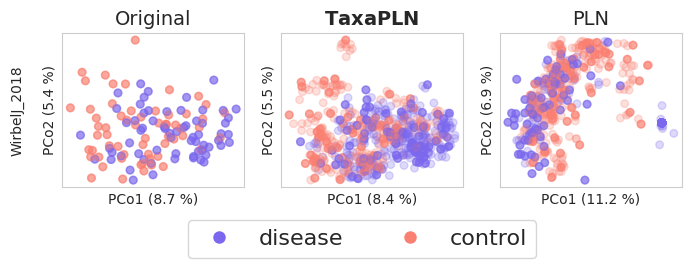

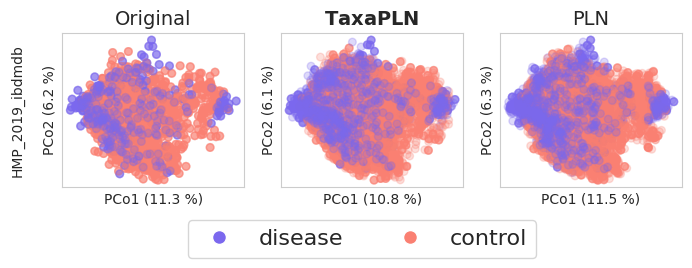

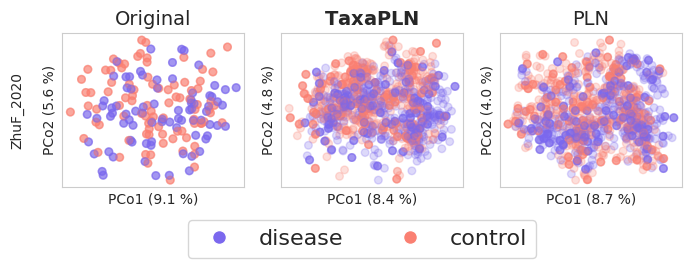

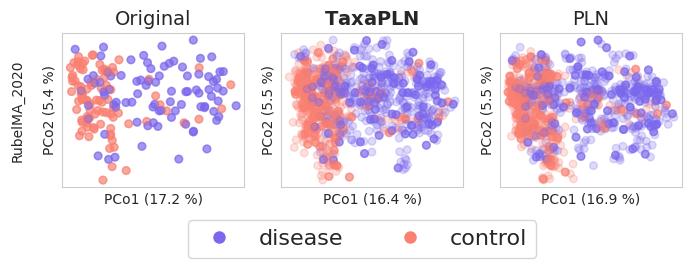

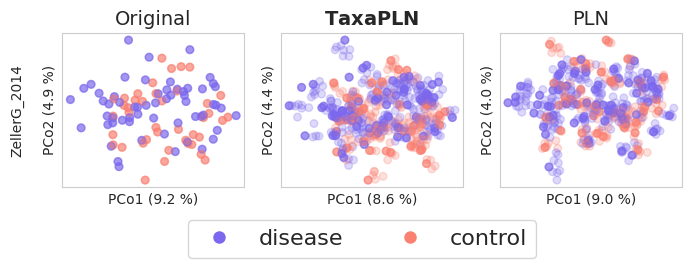

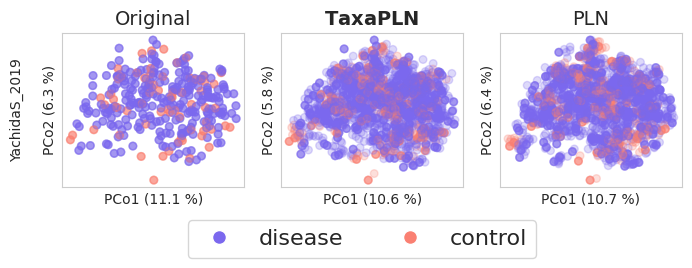

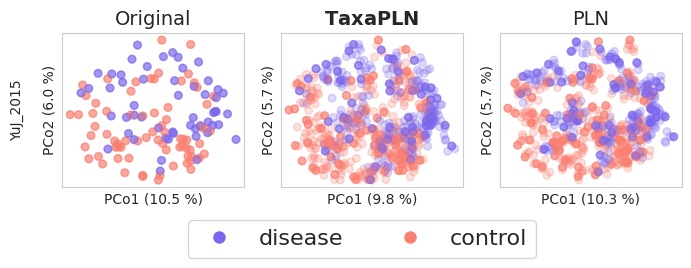

In [41]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity

def _align_pcoa_signs(target, reference, axes=('PC1', 'PC2')):
    """
    Flip each axis of `target` so it correlates positively with `reference`.
    """
    common = target.samples.index.intersection(reference.samples.index)
    if len(common) < 2:          # nothing to align
        return target

    for ax in axes:
        r = np.corrcoef(target.samples.loc[common, ax],
                        reference.samples.loc[common, ax])[0, 1]
        if r < 0:                # negative correlation -> flip axis
            target.samples[ax] *= -1
    return target


def plot_beta_diversity_pcoa(
        diversity,
        X_, y_,
        ref_pcoa=None,                   # <- NEW
        label_names=('class 0', 'class 1'),
        colors=('#3182bd', '#e6550d'),
        figsize=(6, 5),
        point_size=30,
        ax=None,
        return_pcoa=False,               # <- NEW
        **scatter_kw):
    """
    Display Bray-Curtis or Aitchison PCoA plot.
    If `ref_pcoa` is provided, the two first axes are sign-aligned
    to it so that plots are oriented the same way.
    """
    X_ = np.asarray(X_, dtype=float)
    y_ = np.asarray(y_)
    assert set(np.unique(y_)) <= {0, 1}, f"y must contain only 0 and 1. Current values: {set(np.unique(y_))}"

    if diversity == 'braycurtis':
        X_rel = (X_ + 1e-32) / (X_ + 1e-32).sum(-1, keepdims=True)
        dm = beta_diversity('braycurtis', X_rel)
    elif diversity == 'aitchison':
        X_log = np.log(X_ + 1e-32)
        X_clr = X_log - X_log.mean(axis=-1, keepdims=True)
        dm = beta_diversity('euclidean', X_clr, validate=False)
    else:
        raise ValueError("diversity must be 'braycurtis' or 'aitchison'")

    pcoa_res = pcoa(dm, number_of_dimensions=2, method='fsvd', seed=seed)

    # optional alignment to reference ordination
    if ref_pcoa is not None:
        pcoa_res = _align_pcoa_signs(pcoa_res, ref_pcoa)

    pcoa_df = pcoa_res.samples
    pcoa_df['Group'] = y_
    pcoa_df['Color'] = [colors[int(lbl)] for lbl in y_]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(pcoa_df['PC1'], pcoa_df['PC2'],
               c=pcoa_df['Color'], alpha=.25, s=point_size, **scatter_kw)

    ax.set_xlabel(f"PCo1 ({pcoa_res.proportion_explained[0]*100:.1f} %)")
    ax.set_ylabel(f"PCo2 ({pcoa_res.proportion_explained[1]*100:.1f} %)")
    ax.grid(False)

    return (ax, pcoa_res) if return_pcoa else ax




diversity = 'aitchison'       # Either 'braycurtis' or 'aitchison'
sns.set_style('whitegrid')

for study in data.keys():
    fig, axs = plt.subplots(1, len(strategies), figsize=(8, 2))

    ref_pcoa = None            # will hold the ordination of the 'None' strategy

    for j, (strategy, (X_, y_)) in enumerate(datasets_studies[study].items()):
        ax, this_pcoa = plot_beta_diversity_pcoa(
            diversity, X_, y_,
            ref_pcoa=ref_pcoa,
            ax=axs[j],
            colors=('salmon', 'mediumslateblue'),
            label_names=data[study],
            return_pcoa=True
        )

        if strategy == 'None':
            ref_pcoa = this_pcoa 

        axs[j].set_xticks([])
        axs[j].set_yticks([])

        if   strategy == 'None':        strategy_name = 'Original'
        elif strategy == 'TaxaPLN':strategy_name = r'$\bf{TaxaPLN}$'
        elif strategy == 'VampPLN':     strategy_name = 'PLN'
        else:                           strategy_name = strategy
        axs[j].set_title(strategy_name.replace('-', '\n'), size=14)

    axs[0].set_ylabel(f'{study}\n\n' + axs[0].get_ylabel())

    custom_lines = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor='mediumslateblue', markersize=10),
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor='salmon', markersize=10)
    ]
    fig.legend(custom_lines, ['disease', 'control'],
               loc='lower center', ncol=2, fontsize=16,
               frameon=True, bbox_to_anchor=(0.5, -0.3))

    savefig(f'conditional-{diversity}-PCoA-{study}', 'jpg', 350)

### Augmentation benchmark

In [73]:
import os

augment_ratio = 2.          # Augmentation ratio, beta
preprocessing = clr         # Preprocessing
classifier_type = 'XGBoost' # Classifier type (RF, XGBoost can accomodate heterogeneous data type)
strategies = [
    'None',
    'TaxaPLN',
    'PLN',
]
n_cv = 25


levels_str = ''
for level in levels:
    levels_str += level
prefix_file = save_folder + f'conditional-plntreeCV-LV{levels_str}-prev{prevalence}-s{seed}'
perfs_study = {}
for study in data.keys():
    print(study, ':')
    perfs_study[study] = {strategy:[] for strategy in strategies}
    for strategy in strategies:
        seed_all(seed)
        filetag = f'{study}_{strategy}_{classifier_type}_{augment_ratio}'
        fold_file = prefix_file + f'-predictions-{filetag}-cv{n_cv-1}-4.csv'
        train_test_datasets = get_cov_train_test_dataset(
                study, 
                n_cv, preprocessing=clr,
                augment_strategy='None' if os.path.isfile(fold_file) else strategy, 
                augment_ratio=augment_ratio, 
                seed=seed
            )
        wrapper = augmented_classifiers(
            filetag, 
            classifier_type, 
            train_test_datasets, 
            preprocessing=lambda x: x, 
            seed=seed,
        )
        scores = evaluate_classifiers(wrapper, metric=average_precision_score)
        perfs_study[study][strategy] = wrapper #scores
        print('   *', strategy, ': AUPRC', np.round(scores.mean()*100, 1), f'({np.round(scores.std()*100, 1)})')

WirbelJ_2018 :
   * None : AUPRC 81.6 (2.9)
   * TaxaPLN : AUPRC 81.8 (3.2)
   * PLN : AUPRC 81.0 (2.1)
HMP_2019_ibdmdb :
   * None : AUPRC 96.6 (0.3)
   * TaxaPLN : AUPRC 96.1 (0.6)
   * PLN : AUPRC 95.5 (0.5)
ZhuF_2020 :
   * None : AUPRC 76.7 (2.4)
   * TaxaPLN : AUPRC 76.7 (3.2)
   * PLN : AUPRC 76.1 (3.2)
RubelMA_2020 :
   * None : AUPRC 82.2 (2.3)
   * TaxaPLN : AUPRC 84.5 (1.8)
   * PLN : AUPRC 83.6 (1.4)
ZellerG_2014 :
   * None : AUPRC 68.2 (4.2)
   * TaxaPLN : AUPRC 69.8 (3.7)
   * PLN : AUPRC 69.5 (4.3)
YachidaS_2019 :
   * None : AUPRC 78.5 (1.6)
   * TaxaPLN : AUPRC 82.7 (1.9)
   * PLN : AUPRC 82.4 (1.8)
YuJ_2015 :
   * None : AUPRC 76.0 (4.4)
   * TaxaPLN : AUPRC 80.0 (4.4)
   * PLN : AUPRC 79.2 (3.0)


In [74]:
metric = average_precision_score
metric_study = {
    scenario:{
        strategy:evaluate_classifiers(wrapper, metric=metric) for strategy, wrapper in wrapper_strategies.items()
    } for scenario, wrapper_strategies in perfs_study.items()
}
per_scenario_mean_gain = {}
per_scenario_mean_std = {}
per_scenario_mean_gain = pd.DataFrame()
per_scenario_mean_std = pd.DataFrame()
for scenario in data:
    data_perf = pd.DataFrame(metric_study[scenario])[strategies]
    per_scenario_mean_gain[scenario] = data_perf.mean(axis=0)
    per_scenario_mean_std[scenario] = data_perf.std(axis=0)
per_scenario_mean_gain = per_scenario_mean_gain*100
per_scenario_mean_std = per_scenario_mean_std*100
per_scenario_mean_gain = per_scenario_mean_gain.loc[per_scenario_mean_gain.mean(axis=1).sort_values(ascending=False).index]
per_scenario_mean_std = per_scenario_mean_std.loc[per_scenario_mean_gain.mean(axis=1).sort_values(ascending=False).index]

0
merged_df = per_scenario_mean_gain.applymap(lambda x: f"{x:.1f}") \
            + " (" + per_scenario_mean_std.applymap(lambda x: f"{x:.1f}") + ")"
merged_df['Avg gain'] = (per_scenario_mean_gain.mean(axis=1) - per_scenario_mean_gain.loc['None'].mean()).apply(lambda x: f"{x:.2f}")

print('VampPLN-Tree mean gains per dataset:\n')
print((per_scenario_mean_gain - per_scenario_mean_gain.loc['None']).applymap(lambda x: f"{x:.1f}%").transpose())

merged_df.transpose()

VampPLN-Tree mean gains per dataset:

                TaxaPLN    PLN  None
WirbelJ_2018       0.2%  -0.5%  0.0%
HMP_2019_ibdmdb   -0.5%  -1.1%  0.0%
ZhuF_2020          0.0%  -0.5%  0.0%
RubelMA_2020       2.4%   1.4%  0.0%
ZellerG_2014       1.6%   1.3%  0.0%
YachidaS_2019      4.1%   3.8%  0.0%
YuJ_2015           3.9%   3.2%  0.0%


TaxaPLN         PLN        None
WirbelJ_2018     81.8 (3.2)  81.0 (2.1)  81.6 (2.9)
HMP_2019_ibdmdb  96.1 (0.7)  95.5 (0.5)  96.6 (0.3)
ZhuF_2020        76.7 (3.3)  76.1 (3.2)  76.7 (2.4)
RubelMA_2020     84.5 (1.9)  83.6 (1.4)  82.2 (2.3)
ZellerG_2014     69.8 (3.7)  69.5 (4.4)  68.2 (4.3)
YachidaS_2019    82.7 (1.9)  82.4 (1.9)  78.5 (1.6)
YuJ_2015         80.0 (4.5)  79.2 (3.1)  76.0 (4.5)
Avg gain               1.68        1.07        0.00

In [75]:
import pandas as pd
import scipy.stats as stats

target = 'TaxaPLN'
others = [s for s in strategies if s != target]
p_values = pd.DataFrame(columns=others)

test = 't-test'

for scenario in data:
    data_perf = pd.DataFrame(metric_study[scenario])[strategies]
    target_data = data_perf[target]
    p_values_per_strategy = {}
    for strategy in others:
        d = target_data - data_perf[strategy]
        if test == 't-test':
            t_stat, p_val = stats.ttest_rel(target_data, data_perf[strategy], alternative='greater') 
        elif test == 'wilcoxon':
            stat, p_val = stats.wilcoxon(target_data, data_perf[strategy], zero_method="pratt", alternative="greater")
        p_values_per_strategy[strategy] = p_val
    p_values.loc[scenario] = p_values_per_strategy


def signifiance(p):
    if p <= 0.0001:
        return '****'
    elif p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return 'ns'
p_sig = p_values.applymap(signifiance)
p_sig

None  PLN
WirbelJ_2018       ns   ns
HMP_2019_ibdmdb    ns  ***
ZhuF_2020          ns   ns
RubelMA_2020     ****    *
ZellerG_2014       ns   ns
YachidaS_2019    ****   ns
YuJ_2015         ****   ns

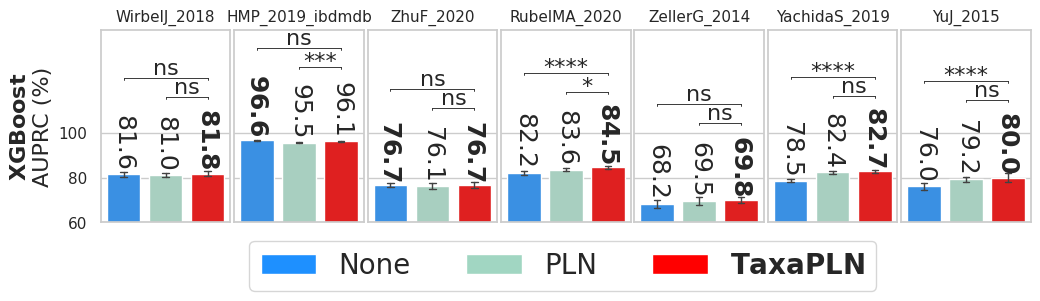

In [76]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats                         

# Plot the performances for each study and augmentation strategy in the covariate-aware experiments

target = 'TaxaPLN'
strategy_colors = {
    'None': '#1E90FF',
    'PLN': '#A1D6C2',
    'TaxaPLN': 'tomato',
    target: 'red',
}

sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(1, len(data), figsize=(12, 2.5), sharey=True,
                        gridspec_kw={'wspace': 0.03})
if not isinstance(axs, np.ndarray):             # in case len(data)==1
    axs = np.array([axs])

y_max = 100.
for i, scenario in enumerate(data):
    # wide → long (needed for seaborn barplot)
    df_wide = (pd.DataFrame(metric_study[scenario])[list(strategy_colors.keys())] * 100)
    df_long = df_wide.melt(var_name='strategy', value_name='score')
    df_long['strategy'] = pd.Categorical(df_long['strategy'],
                                         categories=strategy_colors.keys(),
                                         ordered=True)

    palette = [strategy_colors[s] for s in df_long['strategy'].cat.categories]

    sns.barplot(data=df_long,
                x='strategy',
                y='score',
                order=strategy_colors.keys(),
                palette=palette,
                ax=axs[i],
                estimator=np.mean,
                errorbar=('ci', 95),   
                capsize=0.15,
                errwidth=1.0,
                width=0.8)

    group_stats = df_wide.agg(['mean', 'sem']).T
    group_stats['ci95'] = 1.96 * group_stats['sem']
    for j, (mean_val, ci) in enumerate(zip(group_stats['mean'], group_stats['ci95'])):
        y_text = mean_val + 1.8          # small offset above the error bar
        mean_str = f'{mean_val:.1f}'
        if np.round(mean_val,1) == np.round(group_stats['mean'].max(),1):
            mean_str = '$\\bf{'+mean_str+'}$'
        axs[i].text(j, y_text, mean_str,
                    ha='center', va='bottom', fontsize=18, rotation=-90)

    j_max = len(group_stats) - 1                          # VampPLN‑Tree is last
    vals0 = df_wide[target]
    upper0 = vals0.mean() + 1.96 * stats.sem(vals0) + 20

    for j, col in enumerate(group_stats.index):
        if col == target:
            continue
        other_vals = df_wide[col]
        y = upper0 + 4.5 + (j_max - j) * 8.5

        # horizontal line
        axs[i].plot([j_max, j], [y, y], color='k', lw=0.6)
        # vertical ticks
        axs[i].plot([j_max, j_max], [y, y-1], color='k', lw=0.6)
        axs[i].plot([j, j], [y, y-1], color='k', lw=0.6)

        p_val = p_sig.loc[scenario, col]
        y_textpvalue = y - 0.3
        if '*' in f"{p_val}":
            y_textpvalue = y_textpvalue - 2
        axs[i].text((j_max + j)/2, y_textpvalue, f"{p_val}",
                    ha='center', va='bottom', fontsize=16)
        y_max = max(y_max, y + 8.)
    # cosmetics
    axs[i].set_title(scenario, fontsize=11)
    axs[i].set_ylim(60, y_max)            
    axs[i].set_xlabel('')
    axs[i].set_xticks([])

classifier_name = classifier_type
if classifier_type == 'RF':
    classifier_name = 'Random\;\;Forest'
elif classifier_type == 'logreg':
    classifier_name = 'Logistic\;\;\;Regression'
elif classifier_type == 'mlp':
    classifier_name = 'MLP'
elif classifier_type == 'svm':
    classifier_name = 'svm'
axs[0].set_ylabel('$\\bf{'+classifier_name+'}$\nAUPRC (%)', size=16)
axs[0].set_yticks([tick for tick in axs[0].get_yticks() if tick <= 100])

legend_handles = [Patch(facecolor=color, label=('$\\bf{'+s+'}$' if 'TAXA' in s.upper() else s), lw=1)
                  for s, color in strategy_colors.items()]

fig.legend(handles=legend_handles, loc='lower center', fontsize=20,
           ncol=len(strategy_colors), bbox_to_anchor=(0.51, -0.22),
           frameon=True)
plt.tight_layout()

savefig('conditional-' + classifier_type + f'-ratio{augment_ratio}-preprocCLR-barplot')